In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
#from qids_package.qids import *
#env = make_env()

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import sklearn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")
# color_pal = sns.color_palette()

In [6]:
def interval_split(dt):
    #for date_time column of "sXXdXXpXX"
    f2, f3 = dt.find("d"), dt.find("p")
    return [int(dt[1:f2]), int(dt[f2+1:f3]), int(dt[f3+1:])]

def date_split(dt):
    #for date_time column of "sXXdXX"
    f2 = dt.find("d")
    return [int(dt[1:f2]), int(dt[f2+1:])]


def add_interval(df):
    df_interval_data = np.vstack(df.date_time.apply(lambda x: interval_split(x)))
    df[["asset", "day", "interval"]] = df_interval_data
    return df

def add_date(df):
    df_date_data = np.vstack(df.date_time.apply(lambda x: date_split(x)))
    df[["asset", "day"]] = df_date_data
    return df

print("Ran")

Ran


In [7]:
data_path1 = '''/kaggle/input/hku-qids-2023-quantitative-investment-competition/qids_package/'''
data_path2 = '''/kaggle/input/hku-qids-2023-quantitative-investment-competition/'''
fn_fund = '''first_round_test_fundamental_data.csv'''
fn_market = '''first_round_test_market_data.csv'''
fn_train_fund = '''first_round_train_fundamental_data.csv'''
fn_train_market = '''first_round_train_market_data.csv'''
fn_train_returns = '''first_round_train_return_data.csv'''

df_fund = pd.read_csv(fn_fund)
df_market = pd.read_csv(fn_market)
df_train_fund = pd.read_csv(fn_train_fund)
df_train_market = pd.read_csv(fn_train_market)
df_train_returns = pd.read_csv(fn_train_returns)

df_list = [df_fund, df_market, df_train_fund, df_train_market, df_train_returns]
df_names = ['df_fund', 'df_market', 'df_train_fund', 'df_train_market', 'df_train_returns']
for df, df_name in zip(df_list, df_names):
    print(f"Columns of {df_name} are: {list(df.columns)}")

Columns of df_fund are: ['date_time', 'turnoverRatio', 'transactionAmount', 'pe_ttm', 'pe', 'pb', 'ps', 'pcf']
Columns of df_market are: ['date_time', 'open', 'close', 'high', 'low', 'volume', 'money']
Columns of df_train_fund are: ['date_time', 'turnoverRatio', 'transactionAmount', 'pe_ttm', 'pe', 'pb', 'ps', 'pcf']
Columns of df_train_market are: ['date_time', 'open', 'close', 'high', 'low', 'volume', 'money']
Columns of df_train_returns are: ['date_time', 'return']


# Create Features / Merge all training data into one dataframe

In [8]:
def create_features(market, fundamental, returns=pd.DataFrame([0])):
    market = add_interval(market) 
    fundamental = add_date(fundamental)
    df = pd.merge(market, fundamental, left_on=["asset", "day"], right_on=["asset", "day"])

    if returns.any()[0]:    #check if returns is a non-empty dataframe
        returns = add_date(returns)
        df = pd.merge(df, returns, left_on=["asset", "day"], right_on=["asset", "day"])
    
    df = df.drop_duplicates(subset=["asset", "day"], keep='last').reset_index(drop=True)
    #create new features derived from day (divide by 10 and 100)
    for i in range(2, 14):
        df[f"period{i}"] = df["day"] // i
    for i in range(2, 14):
        df[f"remainder{i}"] = df["day"] % i
    return df


# Train, Predict and Compare Function (Run cells starting Here)

In [9]:
df = create_features(df_train_market, df_train_fund, df_train_returns)

splitter = int(df.shape[0] * 0.7) + 22      #adding is to properly split the asset, since 54 (assets) and 1000 (trading days) is not perfectly divided by 7.
train = df[df.index < splitter]
test = df[df.index >= splitter]

returns_copy = train.copy()
returns_avg = [ returns_copy[returns_copy['asset'] == i]['return'].mean() for i in range(54)]

<Axes: title={'center': 'Asset 33 Returns'}>

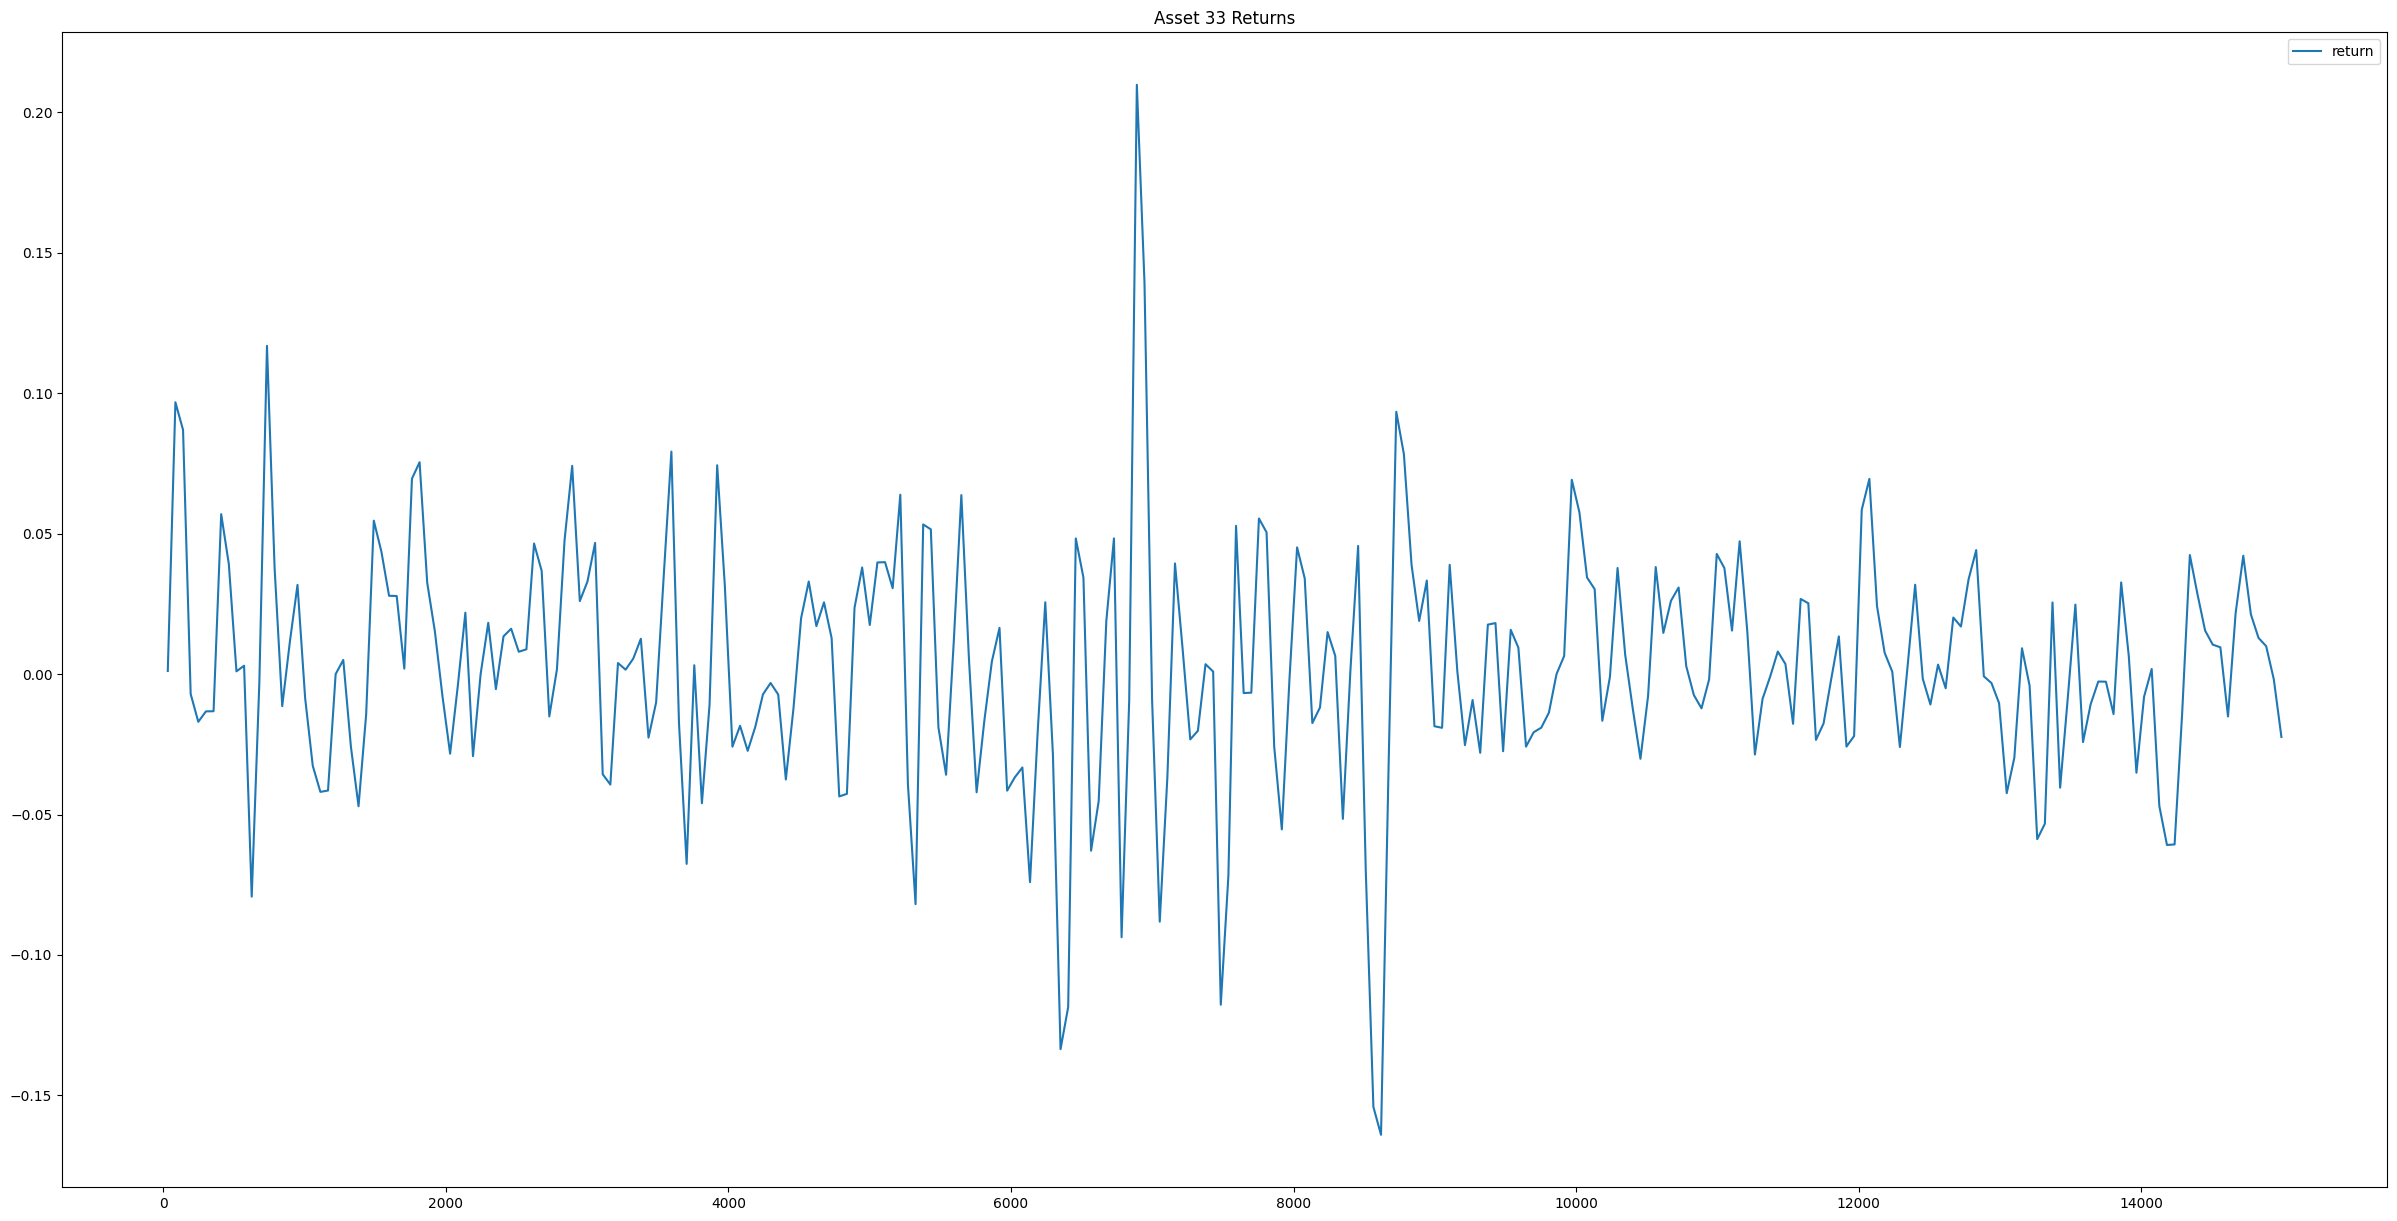

In [10]:
fig, ax = plt.subplots(figsize=(30, 15))
asset_type = 33
df[(df['asset'] == asset_type) & (df.index.isin(range(0, 15000)))][['return']].plot(ax=ax, title=f"Asset {asset_type} Returns")

In [11]:
FEATURES0 = ['asset', 'transactionAmount', 'pe_ttm', 'pe']
FEATURES1 = ['open', 'close', 'high', 'low', 'volume', 'money','turnoverRatio','transactionAmount', 'pe_ttm', 'pe', 'pb', 'ps', 'pcf']
FEATURES2 = ['pcf', 'pe', 'pb', 'pe_ttm', 'ps', 'transactionAmount', 'turnoverRatio', 'money']
FEATURES3 = ['pcf', 'pe', 'pb', 'pe_ttm', 'ps', 'transactionAmount', 'turnoverRatio', 'money', 'open', 'close', 'high', 'low']
FEATURES4 = ['pcf', 'pe', 'pb', 'pe_ttm', 'ps', 'transactionAmount', 'turnoverRatio', 'money', 'open', 'close', 'high', 'low'] + [f"period{i}" for i in range(2, 14)] + [f"remainder{i}" for i in range(2, 14)]
feature_list = [FEATURES0, FEATURES1, FEATURES2, FEATURES3, FEATURES4]
TARGET = 'return'    #always

def train_predict_compare(train, test, asset_type, features, RETURN_FI=False, RETURN_RESULTS=False):
    train = train[train['asset'] == asset_type]
    test = test[test['asset'] == asset_type]

    x_train = train[features]
    y_train = train[TARGET]
    x_test = test[features]
    y_test = test[TARGET]   #only exists for training set

    reg = xgb.XGBRegressor(n_estimators=2000,
                        booster="gbtree",
                        objective="reg:linear",
                        max_depth=2,            #high value leads to overfitting
                        learning_rate=0.3,
                        min_child_weight=3,             #higher value prevent overfitting (1000:700 ratio makes it easy to overfit)
                        subsample=1,
                        )
    
    reg.fit(x_train, y_train, 
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=False)

    fi = pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=['importance'])
    if RETURN_FI:   #used for debugging which feature is more significant 
        return fi

    test['prediction'] = reg.predict(x_test)
    df_progress = pd.merge(df, test[['asset', 'day', 'prediction']],
                            left_on=["asset", "day"], 
                            right_on=["asset", "day"])
    
    df_progress = df_progress[['date_time_x', 'return', 'prediction']]

    ax = df_progress[['return']].plot(figsize=(30, 15))
    df_progress[['prediction']].plot(ax=ax, style=".")

    #experiment on adjusting the returns
    avg_adjusted_prediction = df_progress['prediction'] - (df_progress['prediction'].mean() - returns_avg[asset_type])
    avg_adjusted_prediction.plot(ax=ax, style="--")

    print(f"actual average of returns of real returns = {df_progress['return'].mean()}")
    print(f"average of returns of unadjusted returns = {df_progress['prediction'].mean()}")
    print(f"average of returns of adjusted returns = {avg_adjusted_prediction.mean()}")

[23:18:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
actual average of returns of real returns = -0.0008894586321740023
average of returns of unadjusted returns = 0.0471356138586998
average of returns of adjusted returns = 0.003355257445946336
None
[23:18:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
actual average of returns of real returns = -0.0025439278232597695
average of returns of unadjusted returns = 0.06681456416845322
average of returns of adjusted returns = 0.0020699757151305676
None
[23:18:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now depre

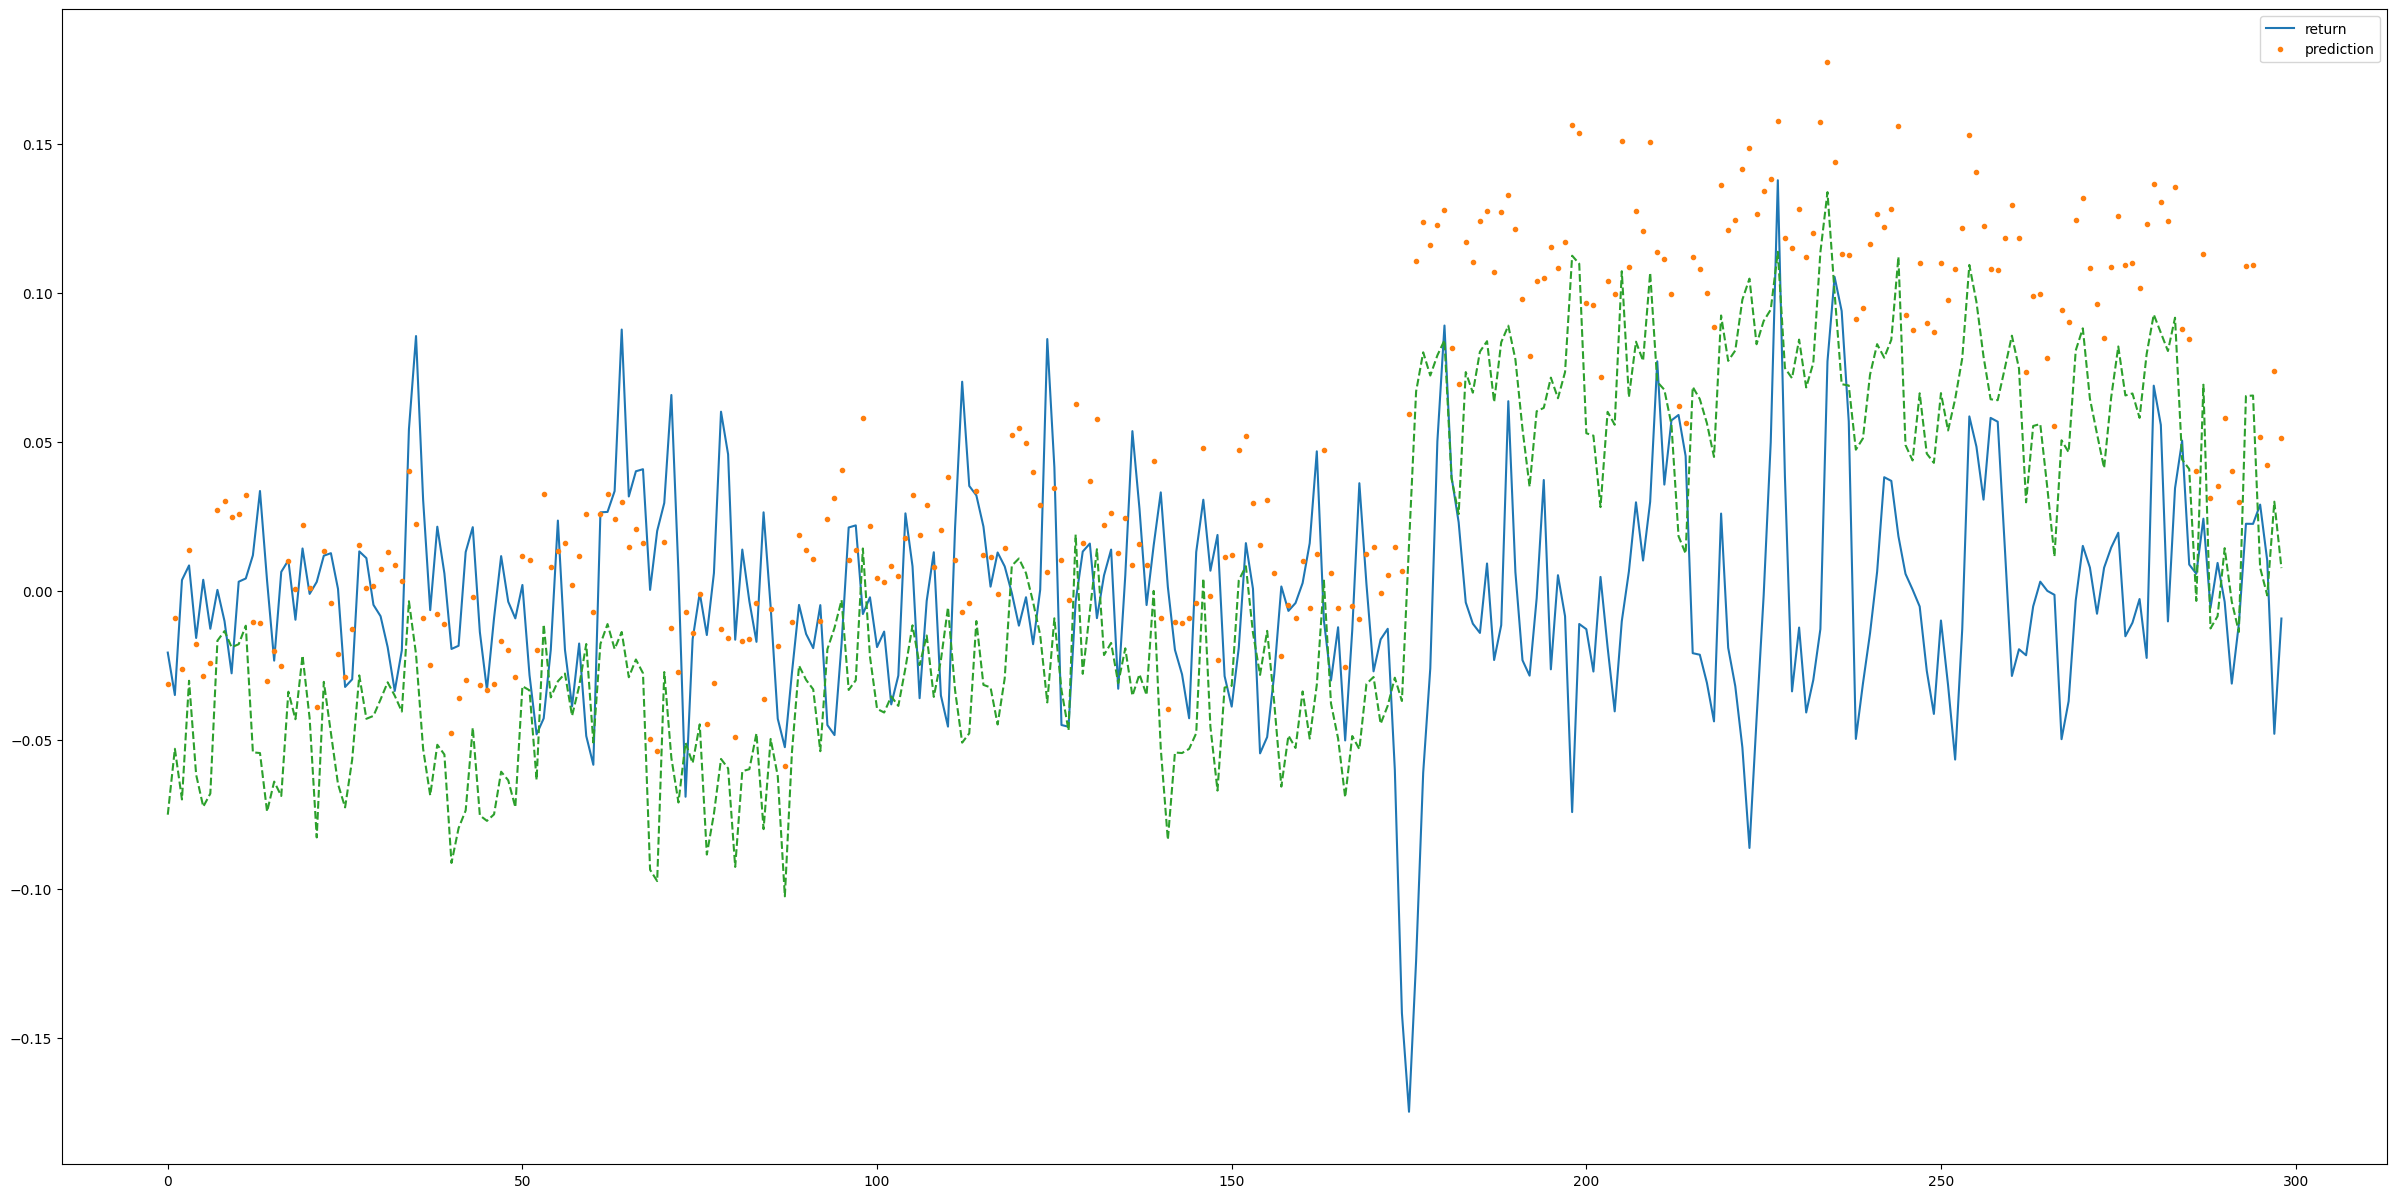

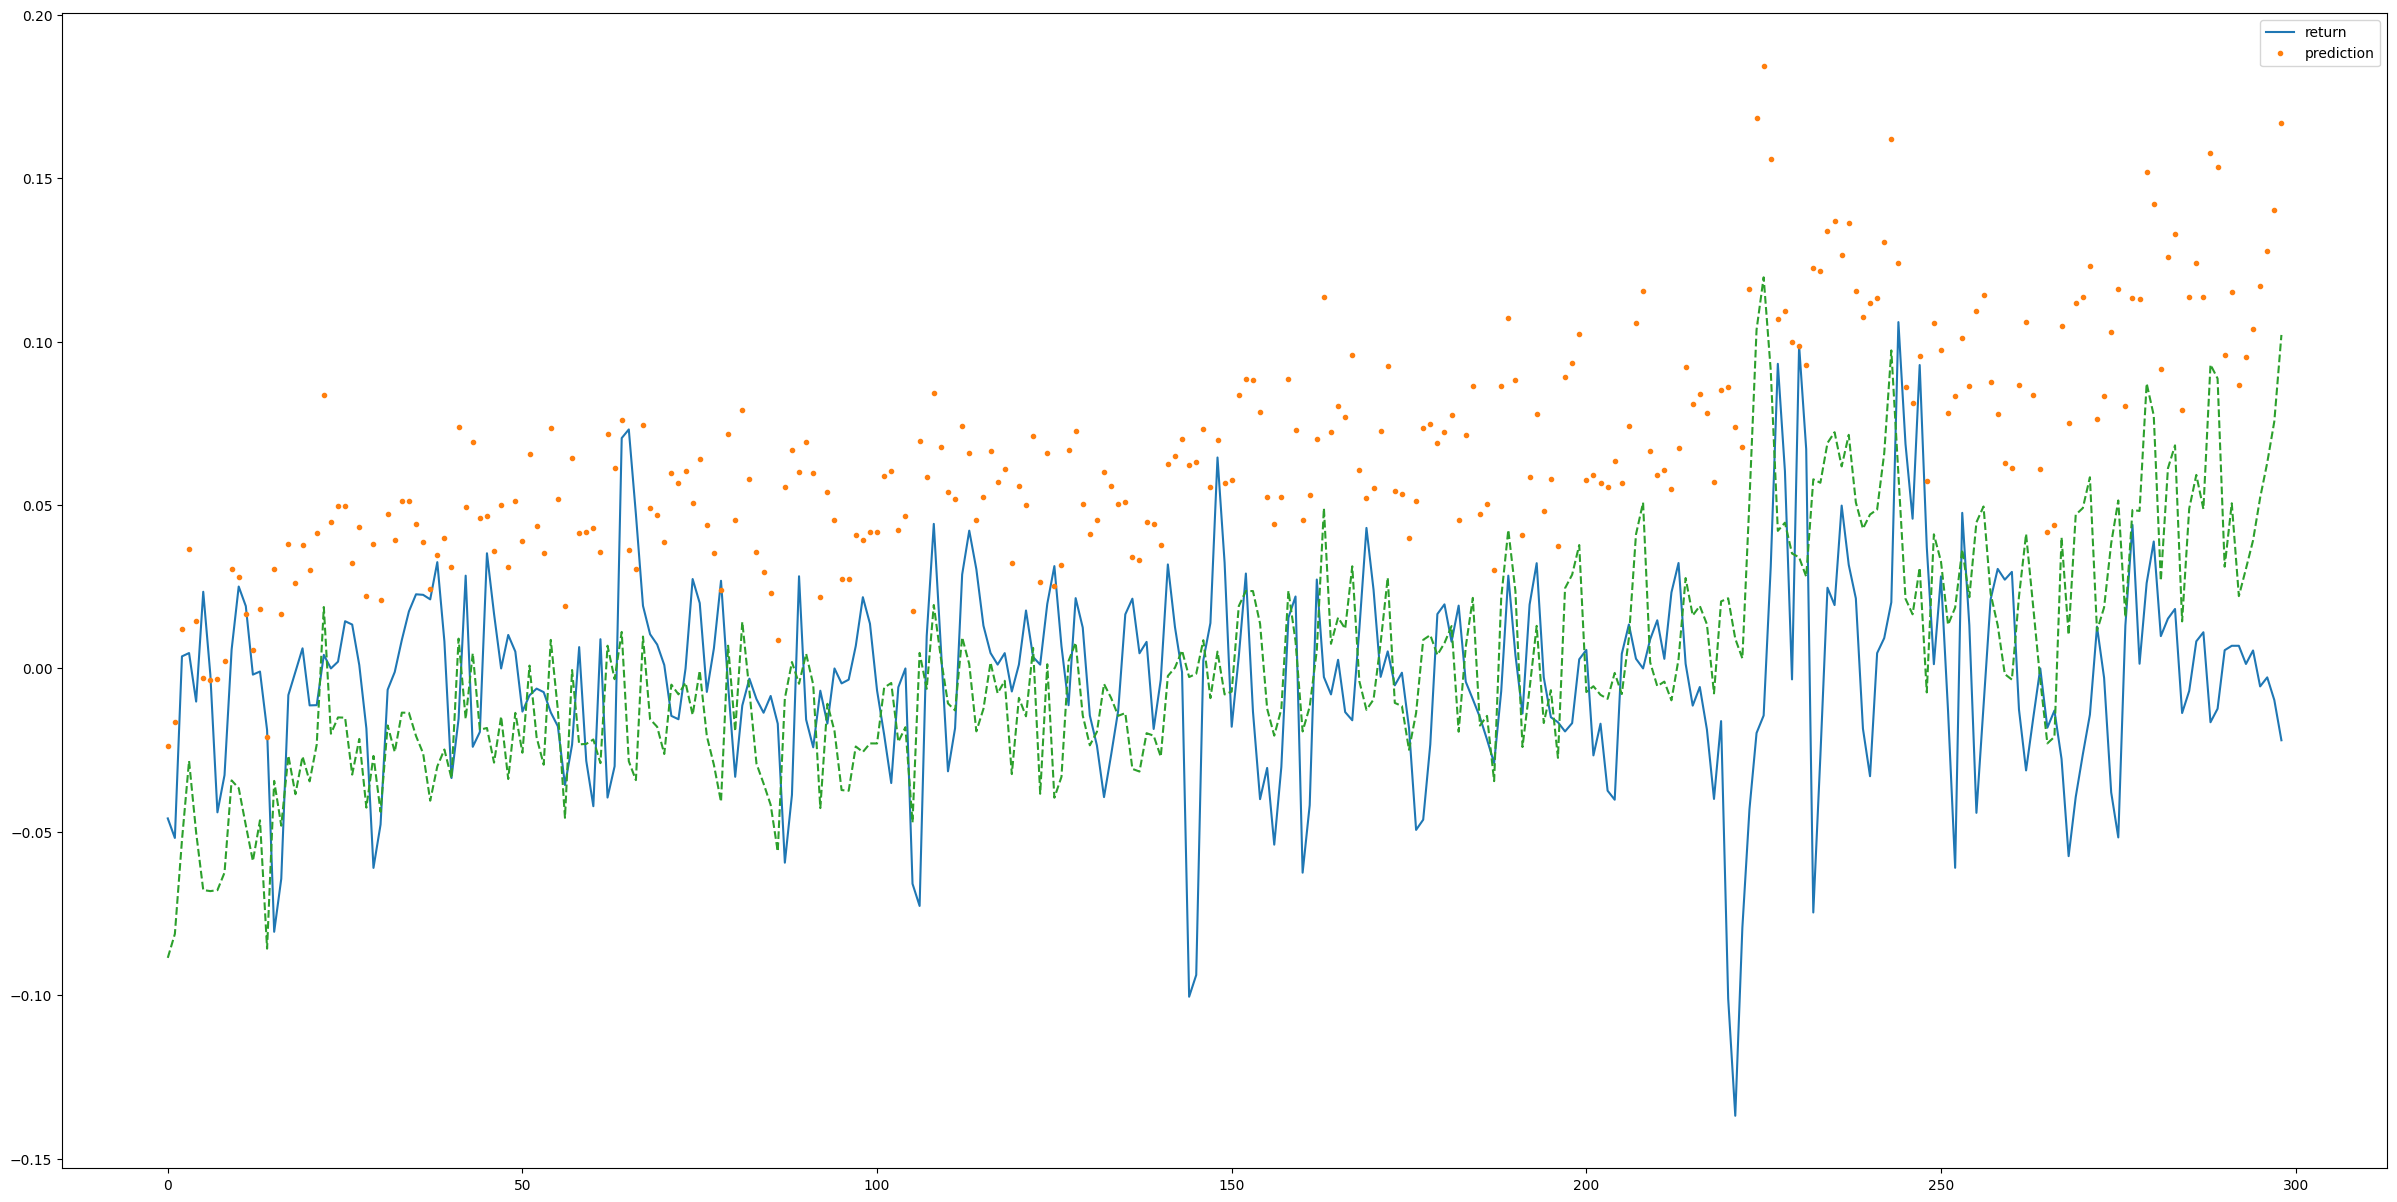

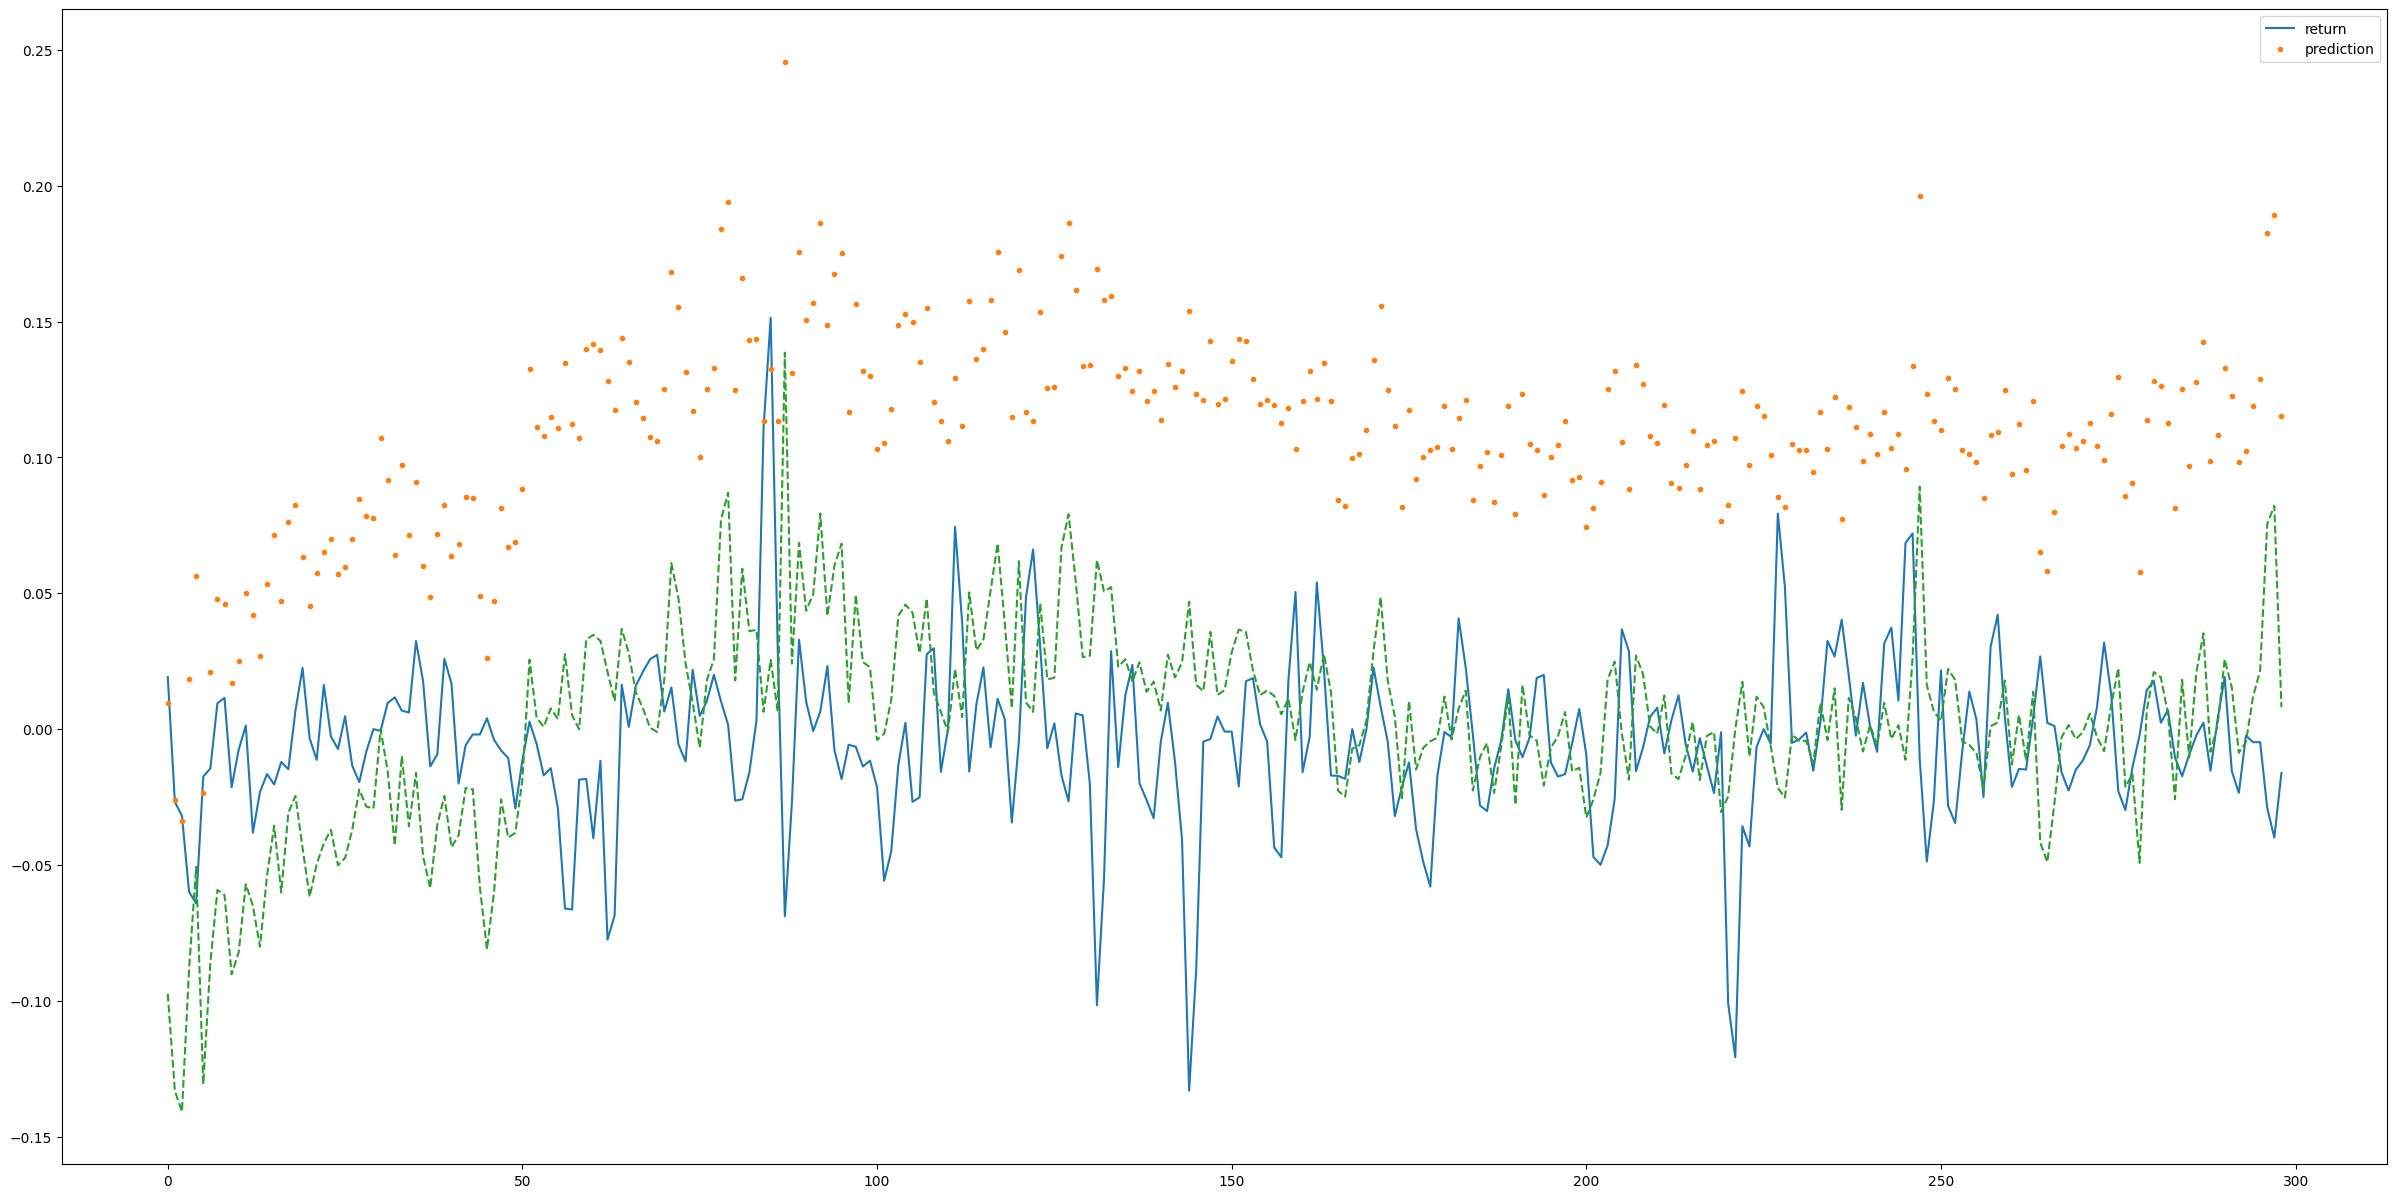

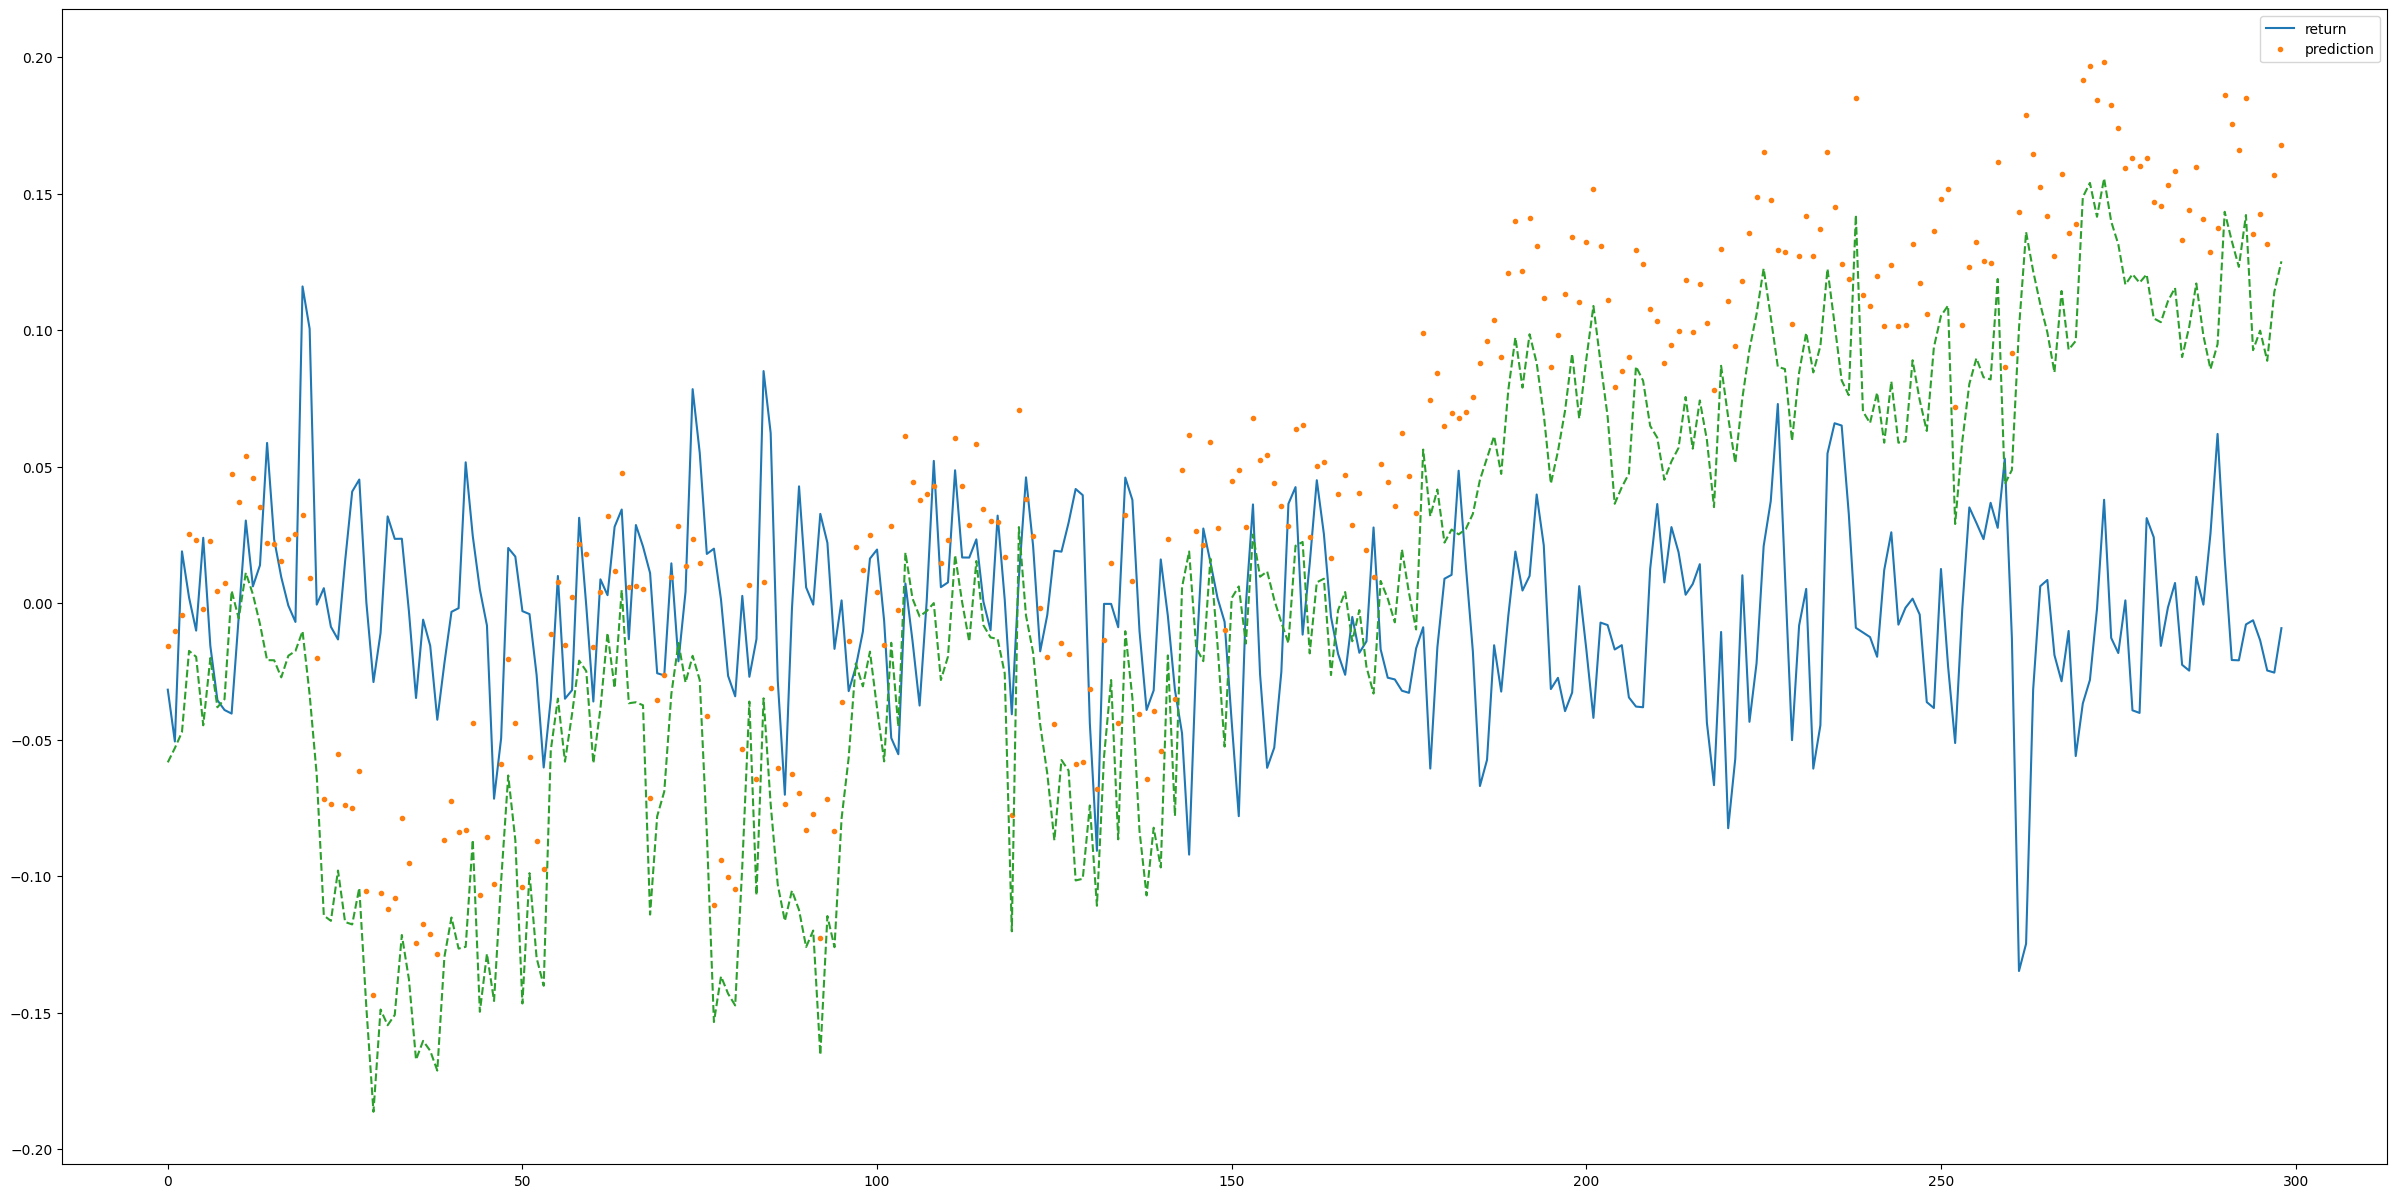

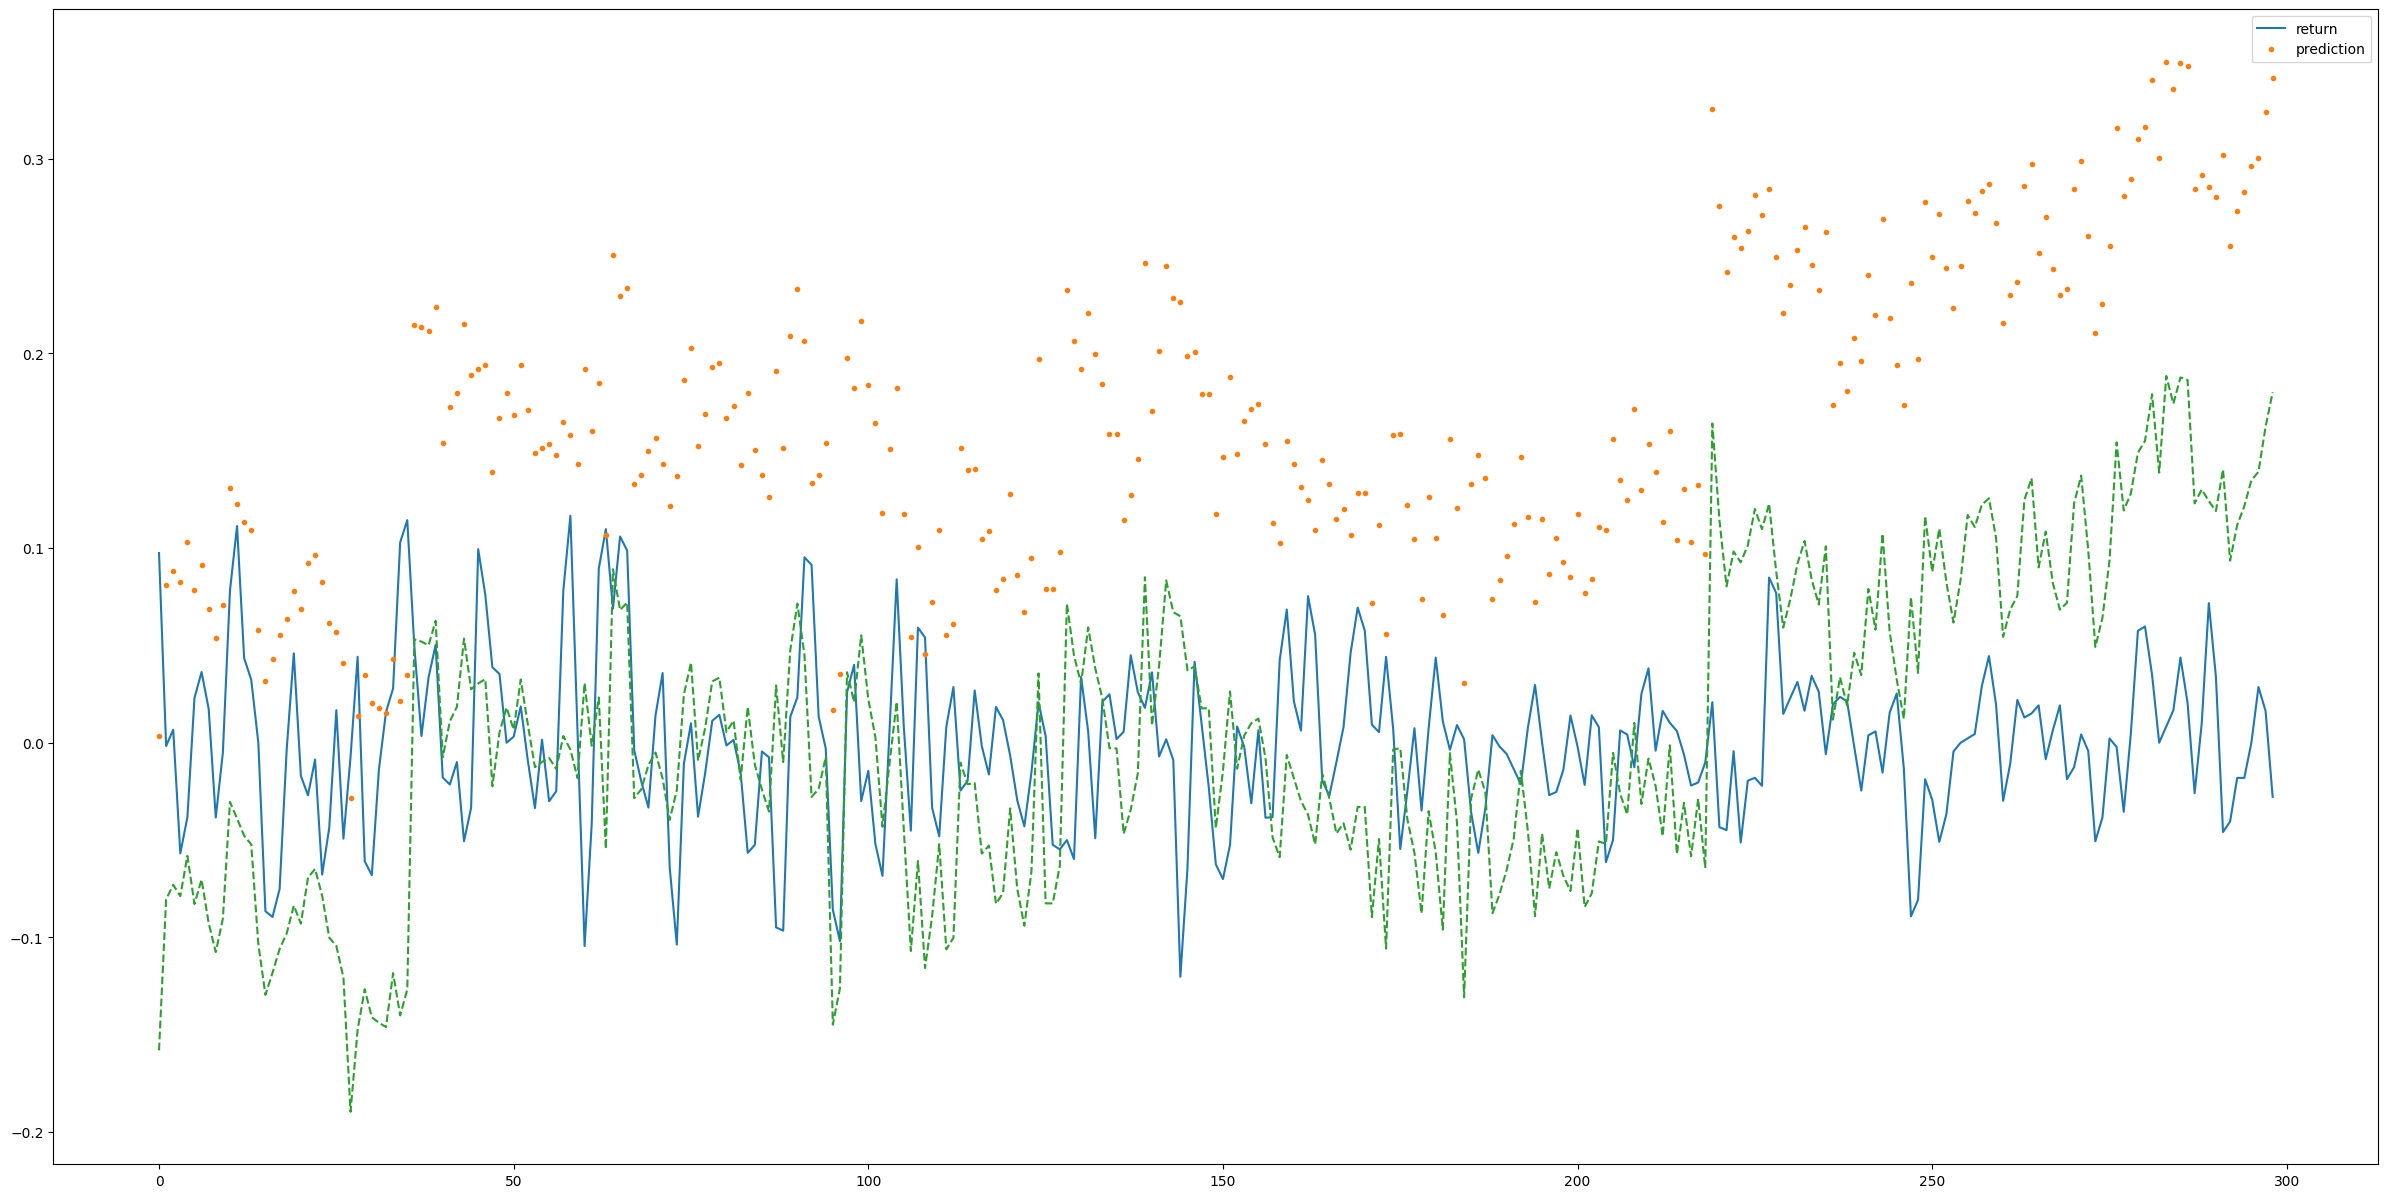

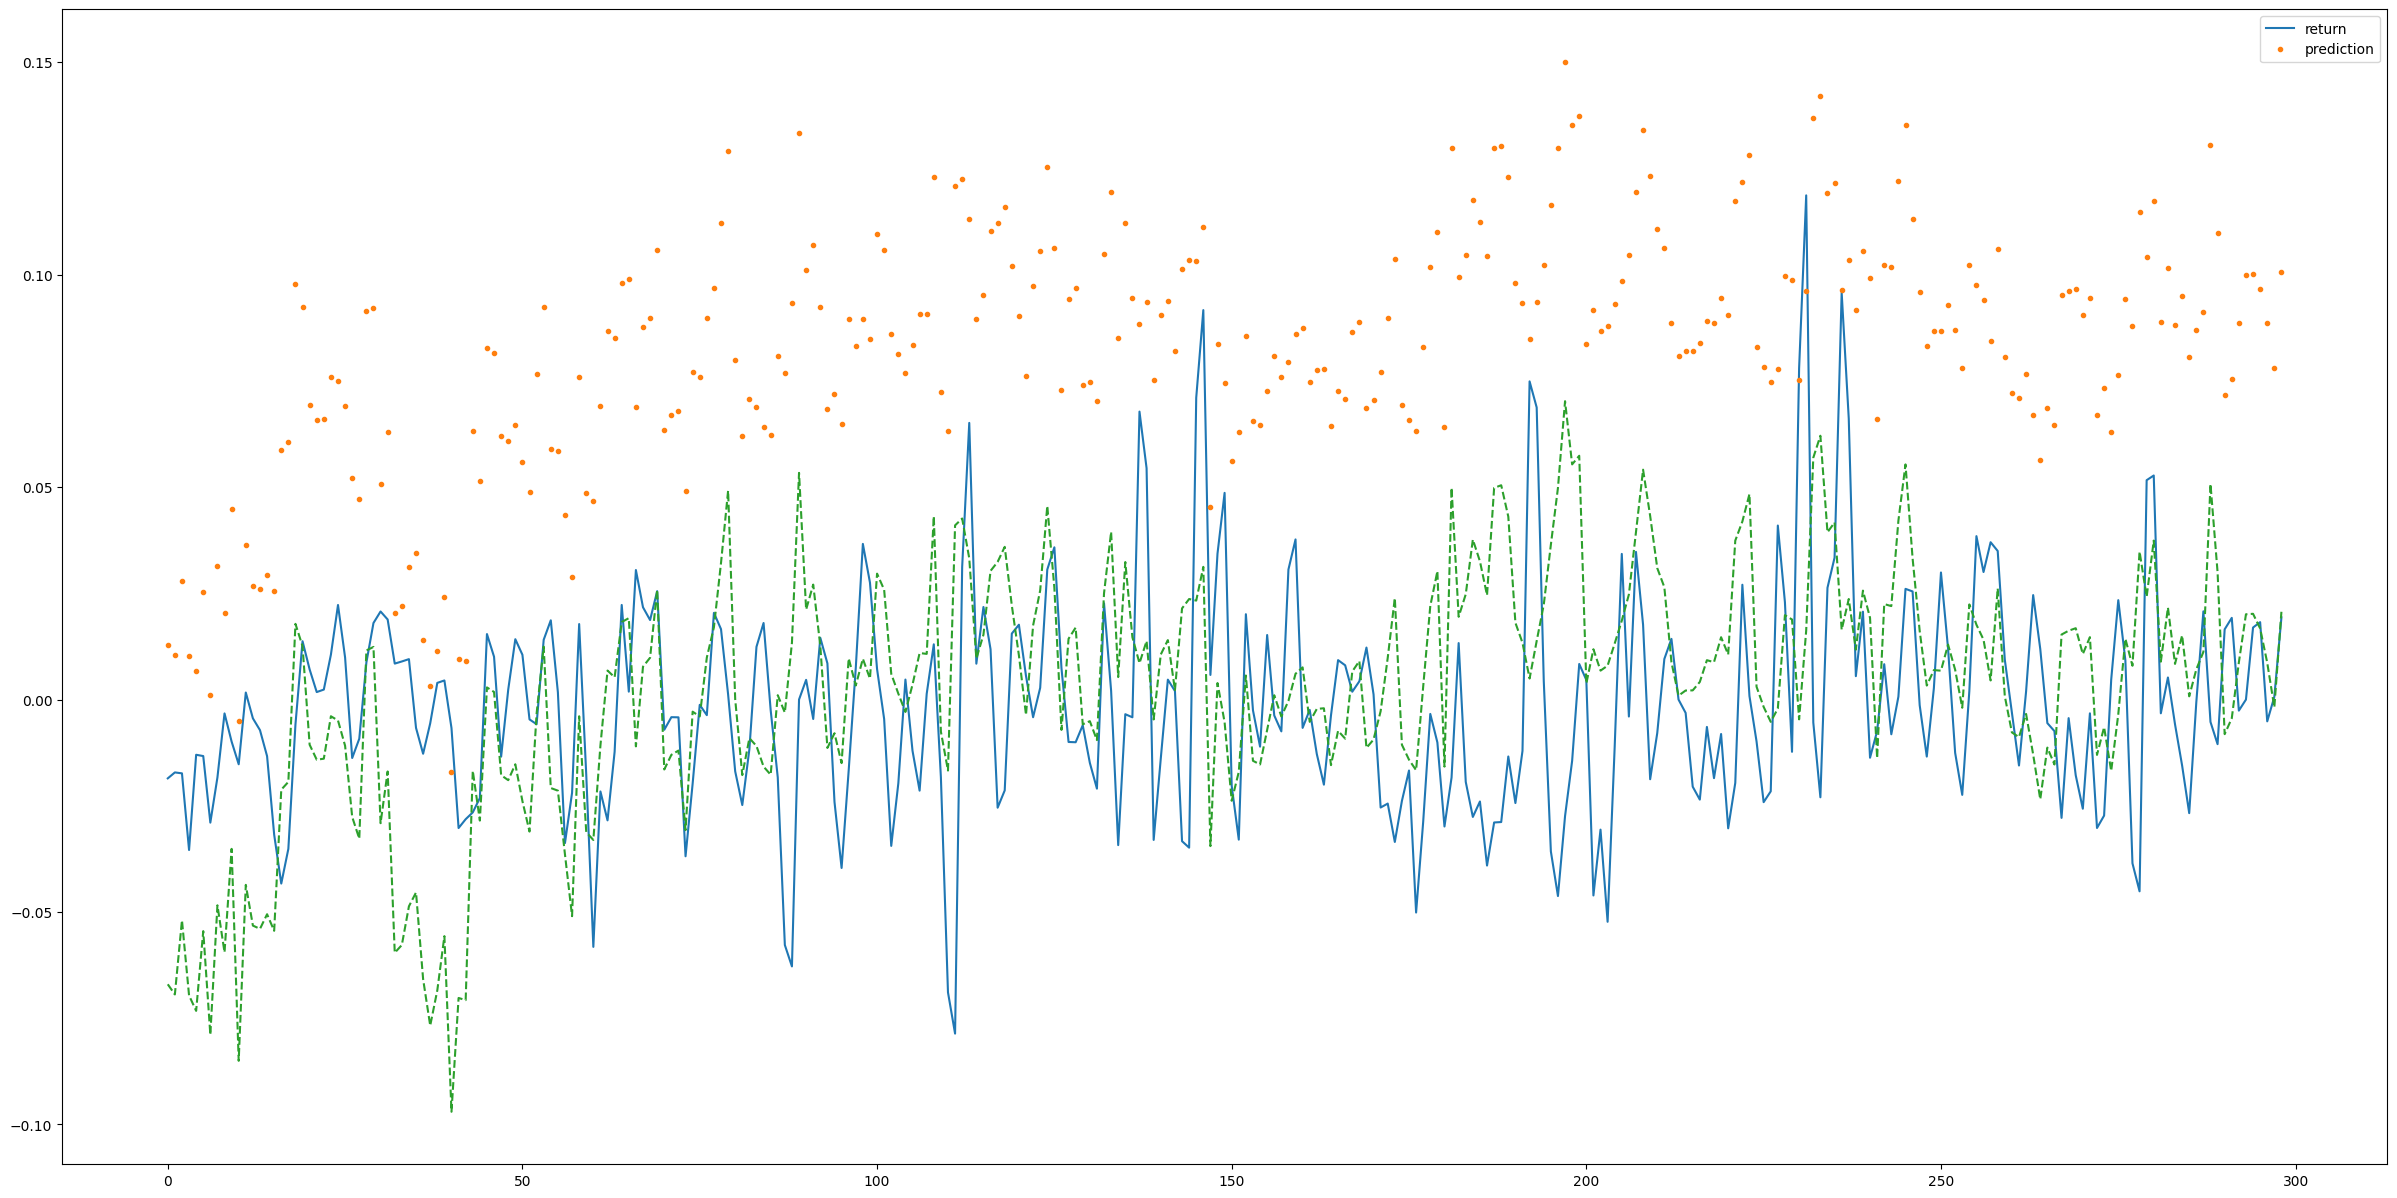

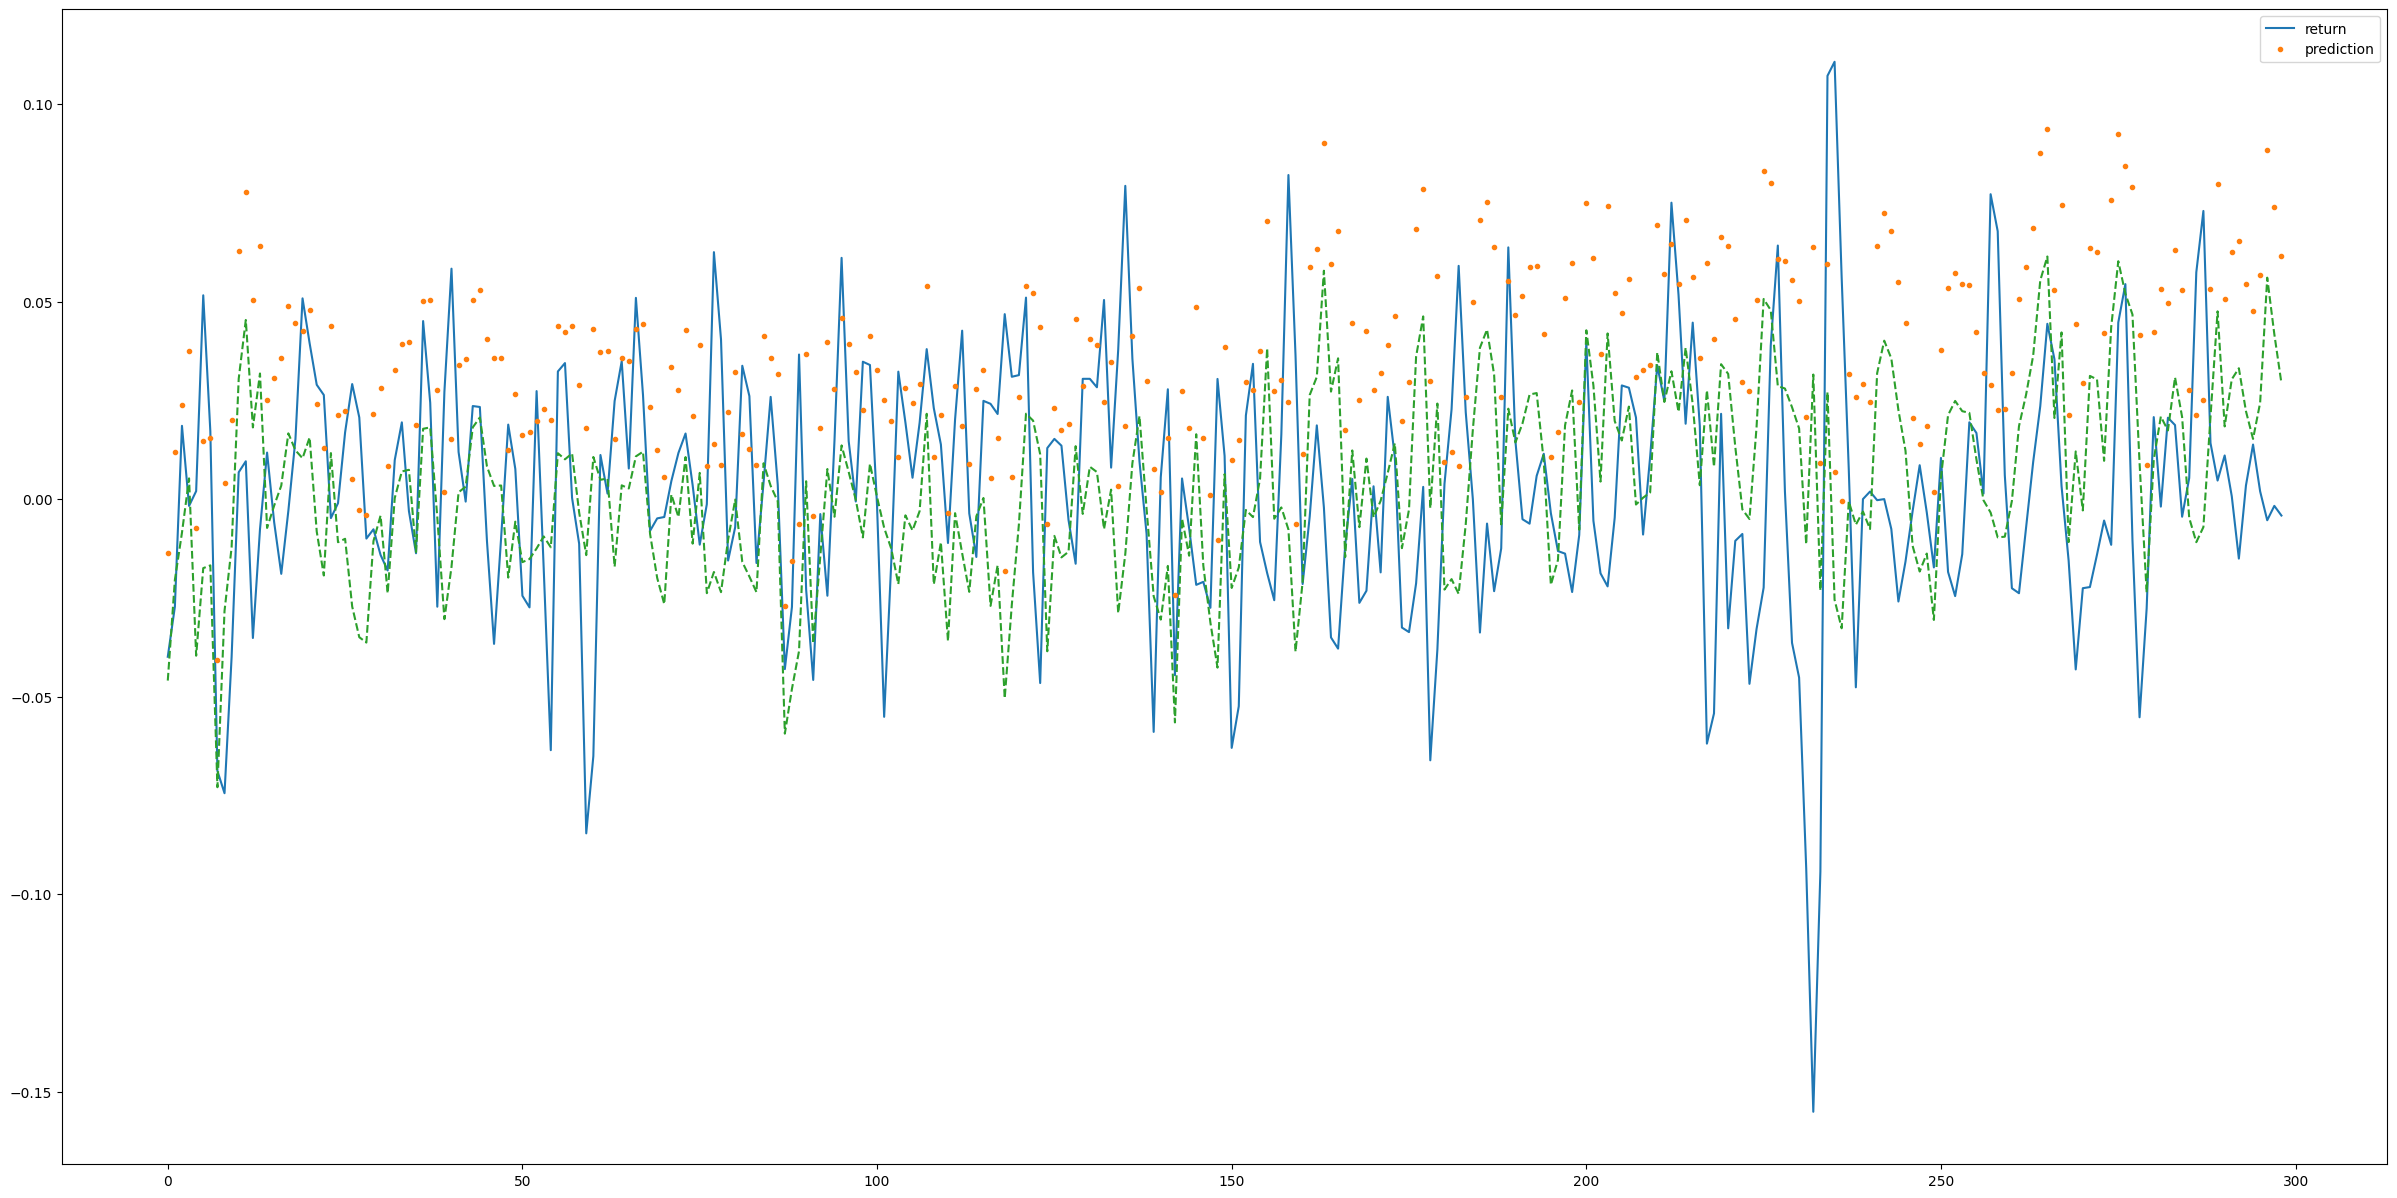

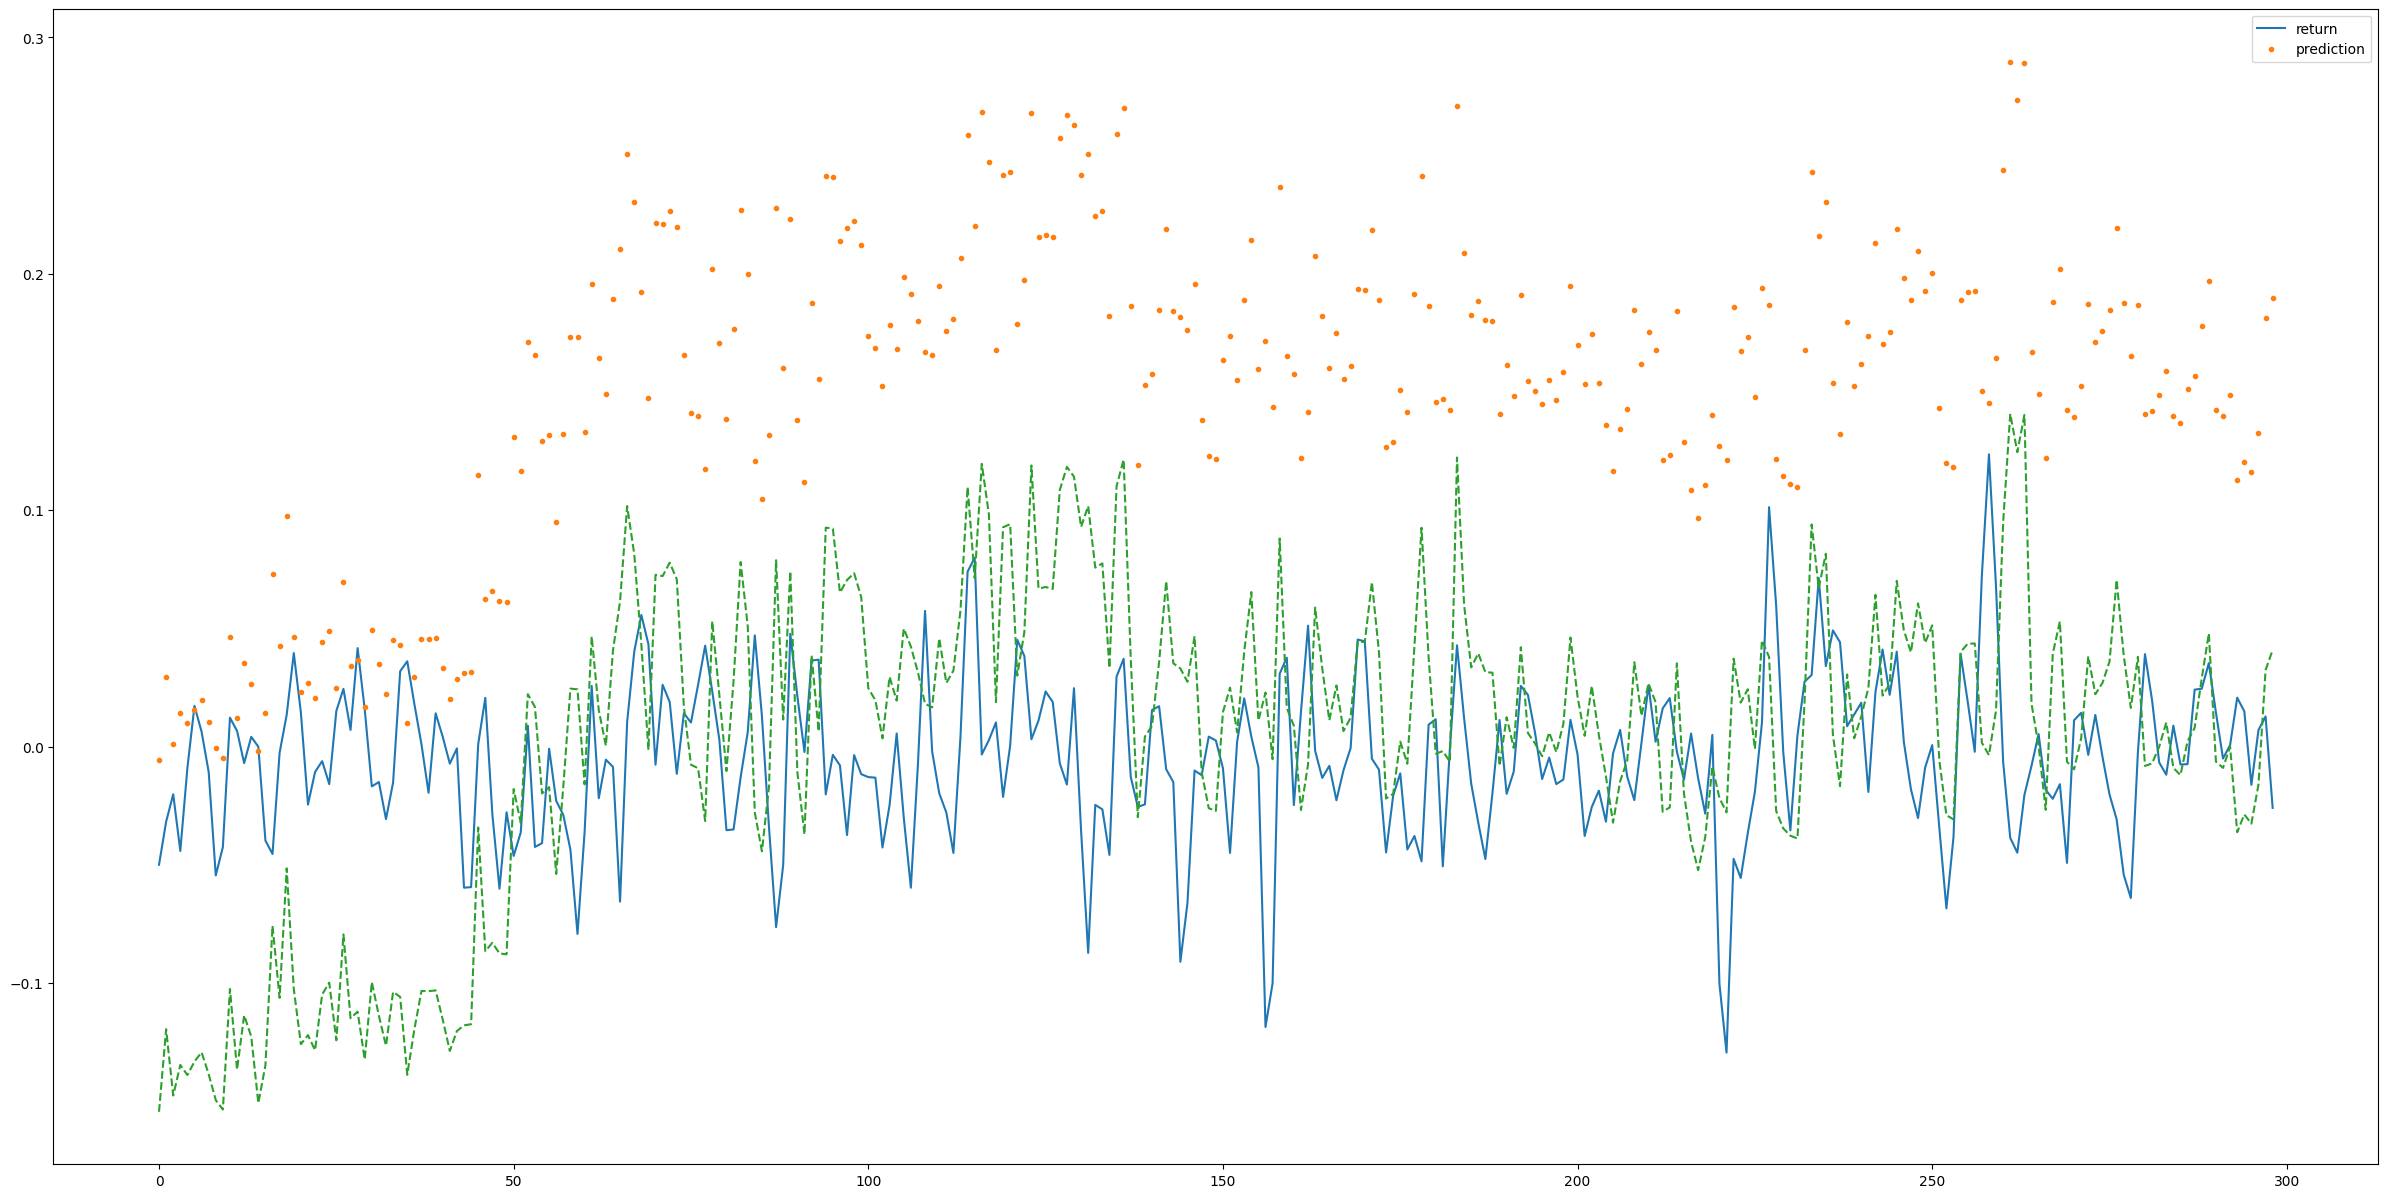

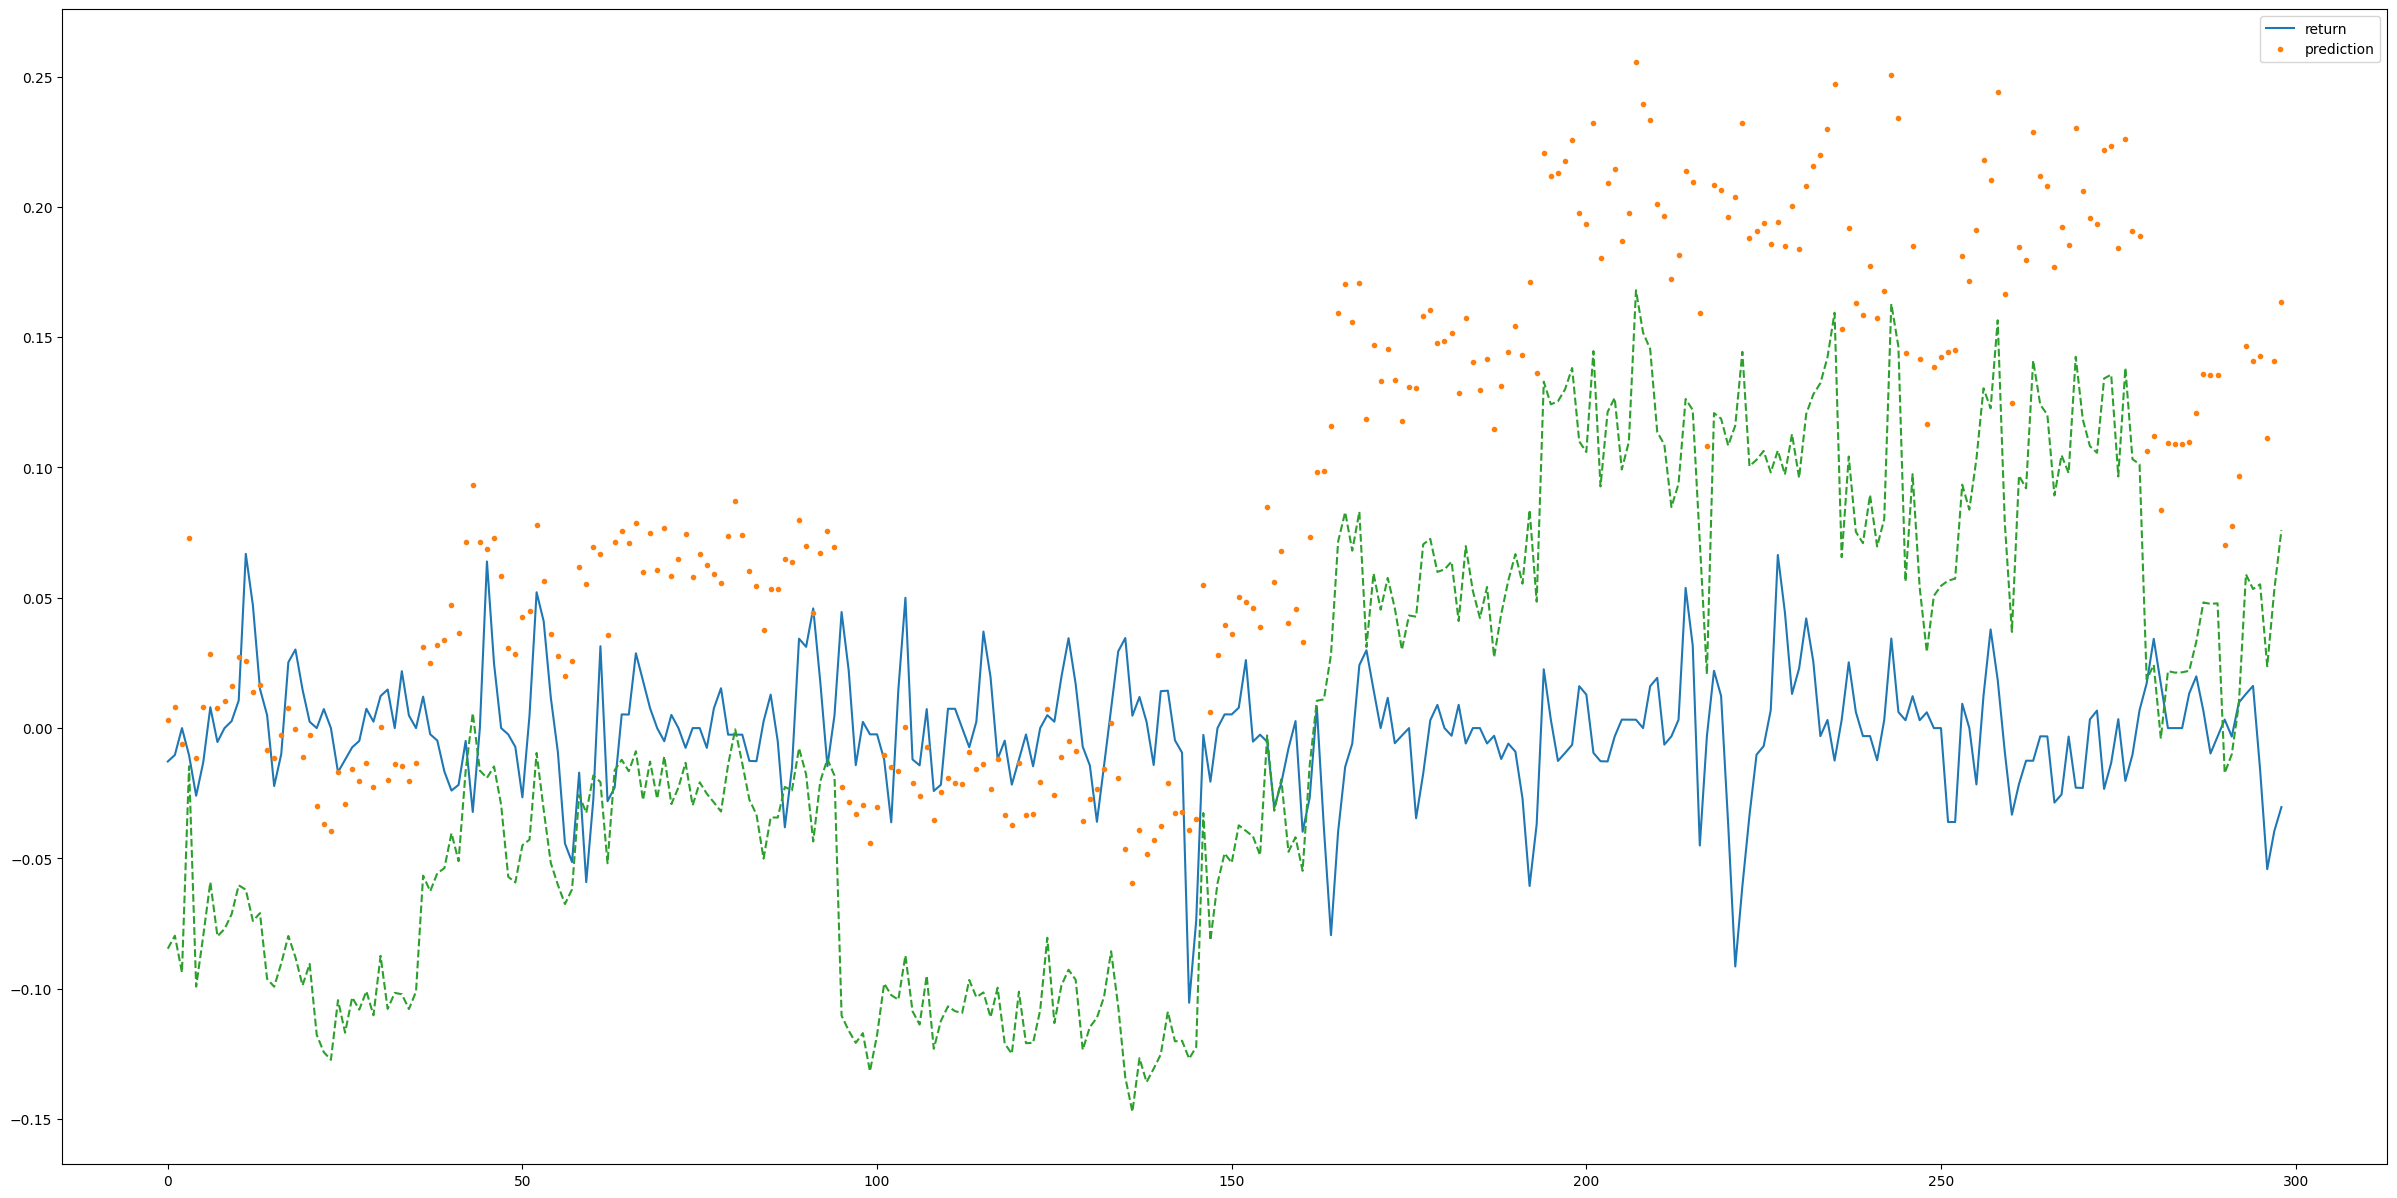

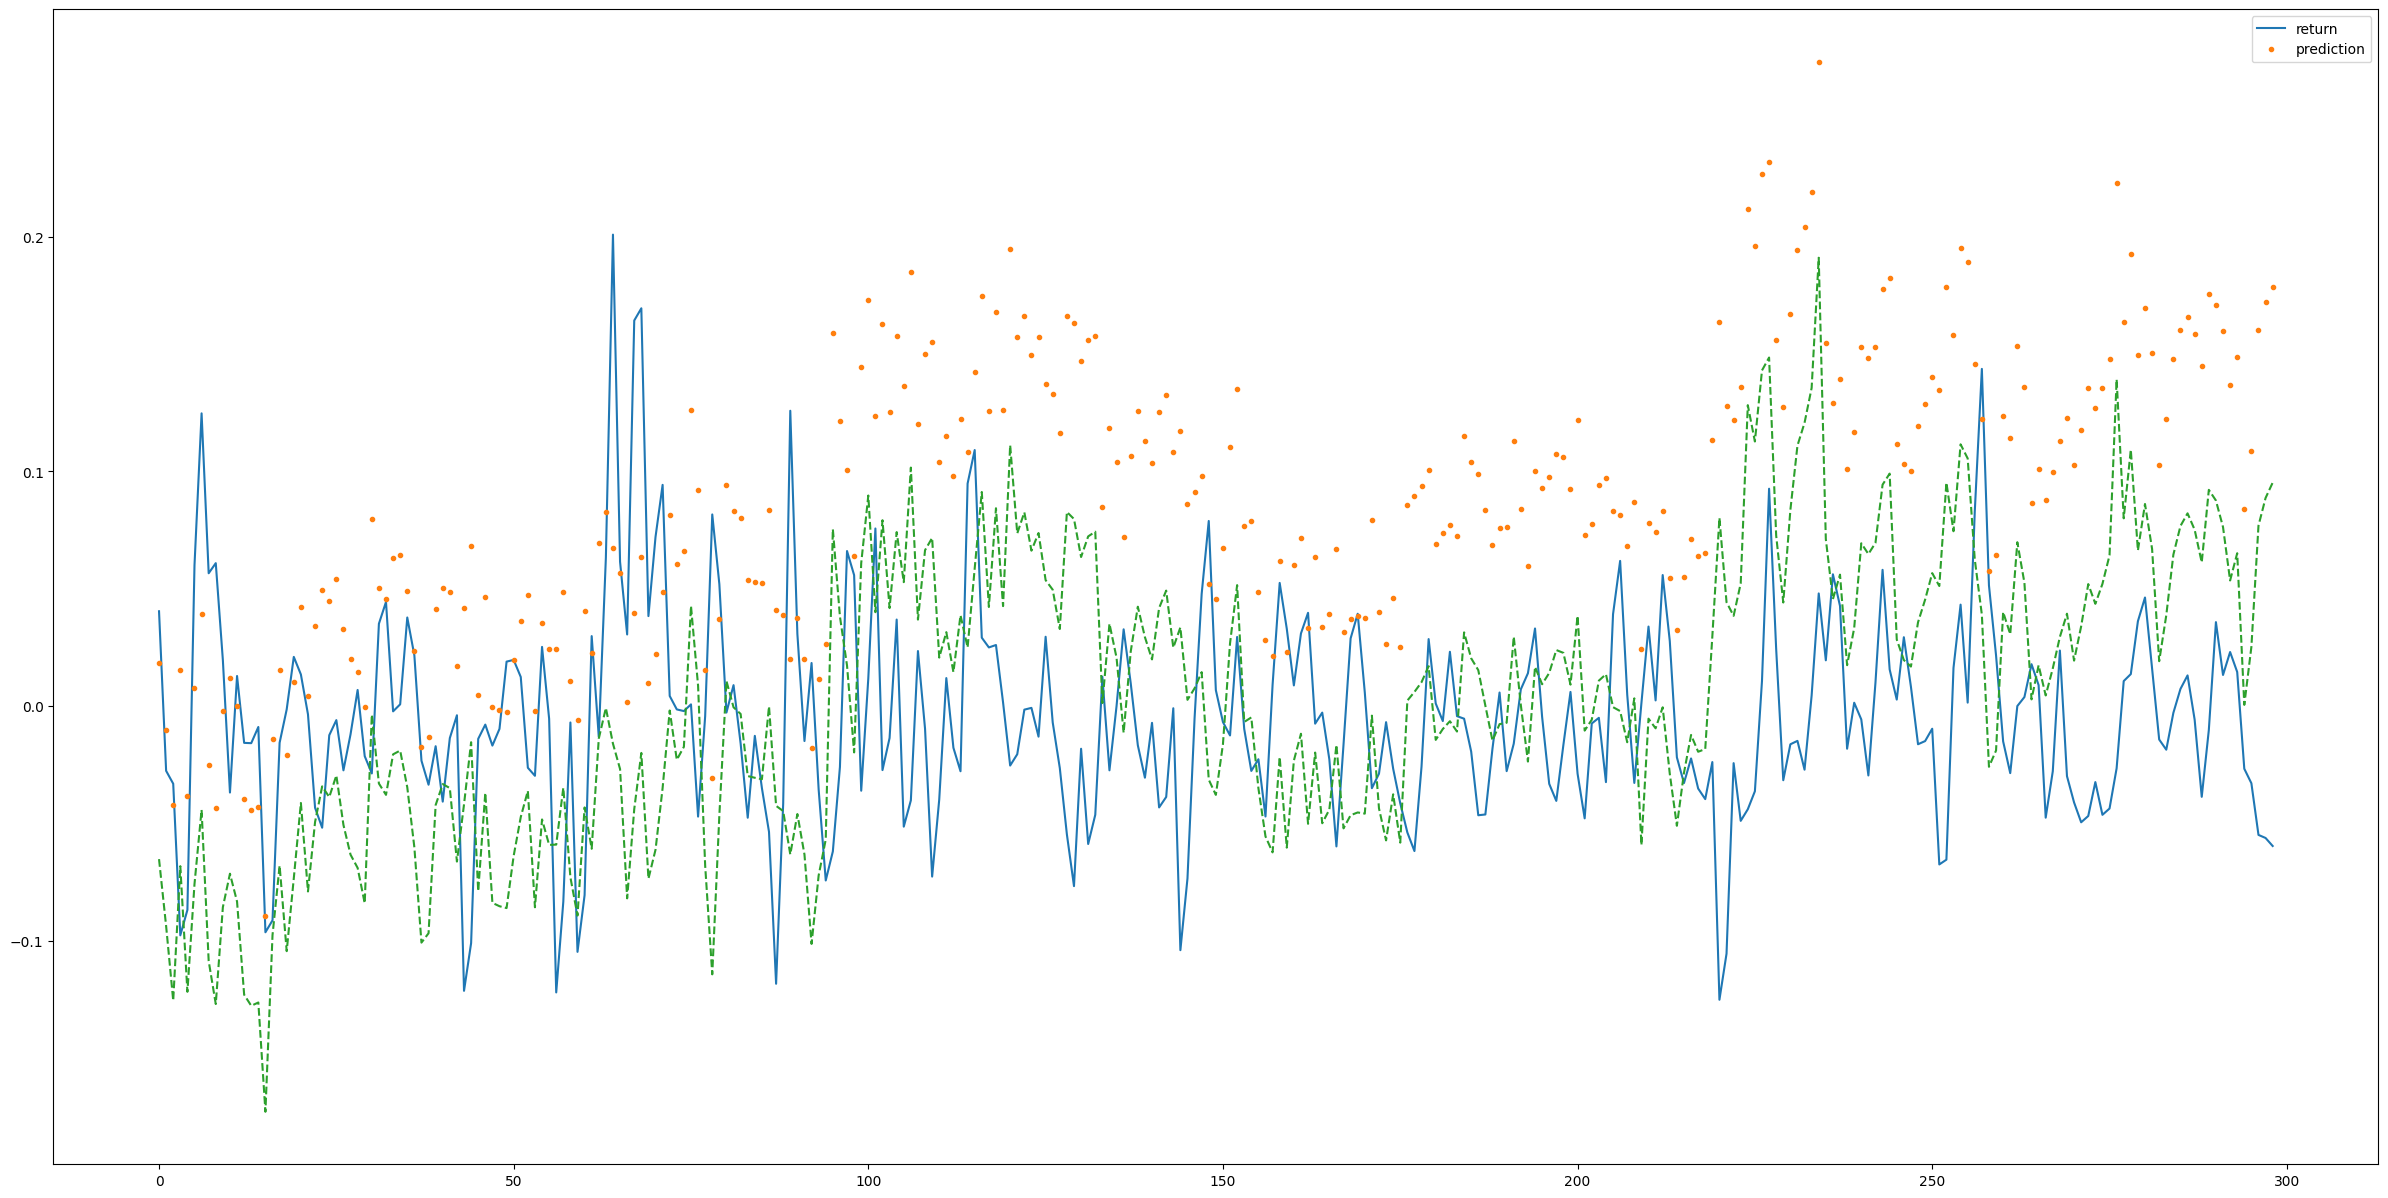

In [12]:
for i in range(1, 20, 2):
    print(train_predict_compare(train, test, i, feature_list[4], False, False))

# Create Model

In [13]:
df = create_features(df_train_market, df_train_fund, df_train_returns)

# THE FOLLOWING ARE THE ABOVE FUNCTION SPLIT UP FOR DEBUGGING AND DEVELOPING (Run Cells Starting Here)

In [14]:
splitter = int(df.shape[0] * 0.7) + 22      #adding is to properly split the asset, since 54 (assets) and 1000 (trading days) is not perfectly divided by 7.
train = df[df.index < splitter]
test = df[df.index >= splitter]

In [15]:
train.tail()        #check if the split is right on the assets (last column should be 53)

date_time_x     open    close     high      low    volume         money  \
37741  s49d699p50  24.2517  24.2274  24.2760  24.1061  589815.0  1.427545e+07   
37742  s50d699p50  13.4489  13.4489  13.4489  13.4489   60564.0  8.132314e+05   
37743  s51d699p50   5.8748   5.8748   5.8748   5.8627  172991.0  1.015130e+06   
37744  s52d699p50  38.4046  38.4775  38.5260  38.4046  386835.0  1.488172e+07   
37745  s53d699p50  16.8840  16.8840  16.8840  16.8840  436683.0  7.370781e+06   

       asset  day  interval  ... remainder4  remainder5  remainder6  \
37741     49  699        50  ...          3           4           3   
37742     50  699        50  ...          3           4           3   
37743     51  699        50  ...          3           4           3   
37744     52  699        50  ...          3           4           3   
37745     53  699        50  ...          3           4           3   

       remainder7  remainder8  remainder9  remainder10  remainder11  \
37741           6           3           6            9            6   
37742           6           3           6            9            6   
37743           6           3           6            9            6   
37744           6           3           6            9            6   
37745           6           3           6            9            6   

      remainder12  remainder13  
37741           3           10  
37742           3           10  
37743           3           10  
37744           3           10  
37745           3           10  

[5 rows x 44 columns]

In [16]:
#testing for returns shift in final step of train-predict-compare
returns_copy = train.copy()
returns_avg = [ returns_copy[(returns_copy['asset'] == i) & (returns_copy.index < splitter)]['return'].mean() for i in range(54)]

In [17]:
FEATURES0 = ['asset', 'transactionAmount', 'pe_ttm', 'pe']
FEATURES1 = ['open', 'close', 'high', 'low', 'volume', 'money','turnoverRatio','transactionAmount', 'pe_ttm', 'pe', 'pb', 'ps', 'pcf']
FEATURES2 = ['pcf', 'pe', 'pb', 'pe_ttm', 'ps', 'transactionAmount', 'turnoverRatio', 'money']
FEATURES3 = ['pcf', 'pe', 'pb', 'pe_ttm', 'ps', 'transactionAmount', 'turnoverRatio', 'money', 'open', 'close', 'high', 'low']
FEATURES4 = ['pcf', 'pe', 'pb', 'pe_ttm', 'ps', 'transactionAmount', 'turnoverRatio', 'money', 'open', 'close', 'high', 'low'] + [f"period{i}" for i in range(2, 14)] + [f"remainder{i}" for i in range(2, 14)]

feature_list = [FEATURES0, FEATURES1, FEATURES2, FEATURES3, FEATURES4]
TARGET = 'return'    #always

In [18]:
#change asset_type here
asset_type=45   
train = train[train['asset'] == asset_type]
test = test[test['asset'] == asset_type]

# change features here
feature_used = feature_list[4]

x_train = train[feature_used]
y_train = train[TARGET]

x_test = test[feature_used]
y_test = test[TARGET]

reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
reg.fit(x_train, y_train, 
       eval_set=[(x_train, y_train), (x_test, y_test)],
       verbose=True)
print("Model Built and Trained.")

[0]	validation_0-rmse:0.49572	validation_1-rmse:0.49776
[1]	validation_0-rmse:0.49081	validation_1-rmse:0.49284
[2]	validation_0-rmse:0.48595	validation_1-rmse:0.48796
[3]	validation_0-rmse:0.48114	validation_1-rmse:0.48313
[4]	validation_0-rmse:0.47638	validation_1-rmse:0.47836
[5]	validation_0-rmse:0.47166	validation_1-rmse:0.47363
[6]	validation_0-rmse:0.46699	validation_1-rmse:0.46894
[7]	validation_0-rmse:0.46237	validation_1-rmse:0.46431
[8]	validation_0-rmse:0.45780	validation_1-rmse:0.45972
[9]	validation_0-rmse:0.45327	validation_1-rmse:0.45518
[10]	validation_0-rmse:0.44879	validation_1-rmse:0.45068
[11]	validation_0-rmse:0.44435	validation_1-rmse:0.44622
[12]	validation_0-rmse:0.43996	validation_1-rmse:0.44182
[13]	validation_0-rmse:0.43561	validation_1-rmse:0.43745
[14]	validation_0-rmse:0.43131	validation_1-rmse:0.43313
[15]	validation_0-rmse:0.42705	validation_1-rmse:0.42885
[16]	validation_0-rmse:0.42283	validation_1-rmse:0.42462
[17]	validation_0-rmse:0.41865	validation

# Feature Importance

<Axes: title={'center': 'Feature Importance (ranked)'}>

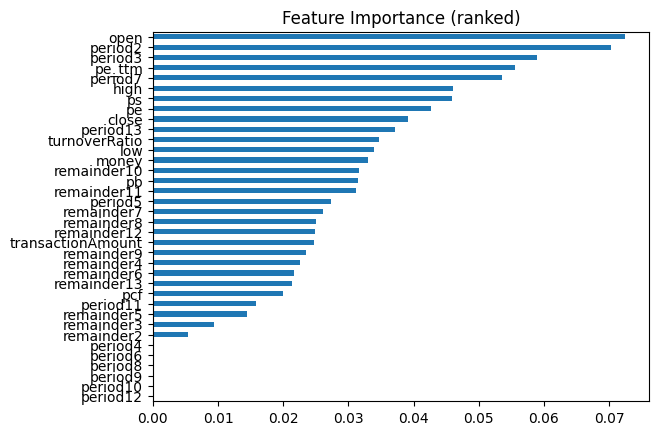

In [19]:
fi = pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title="Feature Importance (ranked)", legend=False)

In [20]:
def accumulate_feature_importance():
    #this function accumlate the FI dataframe of all features used
    df_temp = train_predict_compare(train, test, 0, feature_used, True)
    for i in range(1, 54):
        df_temp += train_predict_compare(train, test, i, feature_used, True)
    df_temp = df_temp.sort_values("importance", ascending=False)
    return df_temp

# Forecasting on Test Sets

In [21]:
test['prediction'] = reg.predict(x_test)
df_progress = pd.merge(df, test[['asset', 'day', 'prediction']],
                        left_on=["asset", "day"], 
                        right_on=["asset", "day"]) 

In [22]:
df_progress[df_progress['asset'] == asset_type][['date_time_x', 'return', 'prediction']]

date_time_x    return  prediction
0    s45d700p50 -0.012303   -0.009679
1    s45d701p50  0.000000   -0.000977
2    s45d702p50  0.024912   -0.000901
3    s45d703p50  0.002218   -0.003557
4    s45d704p50  0.005526   -0.011857
..          ...       ...         ...
294  s45d994p50 -0.003118    0.064252
295  s45d995p50  0.000000    0.039649
296  s45d996p50 -0.017185    0.061981
297  s45d997p50 -0.023368    0.177872
298  s45d998p50 -0.022253    0.049598

[299 rows x 3 columns]

<Axes: >

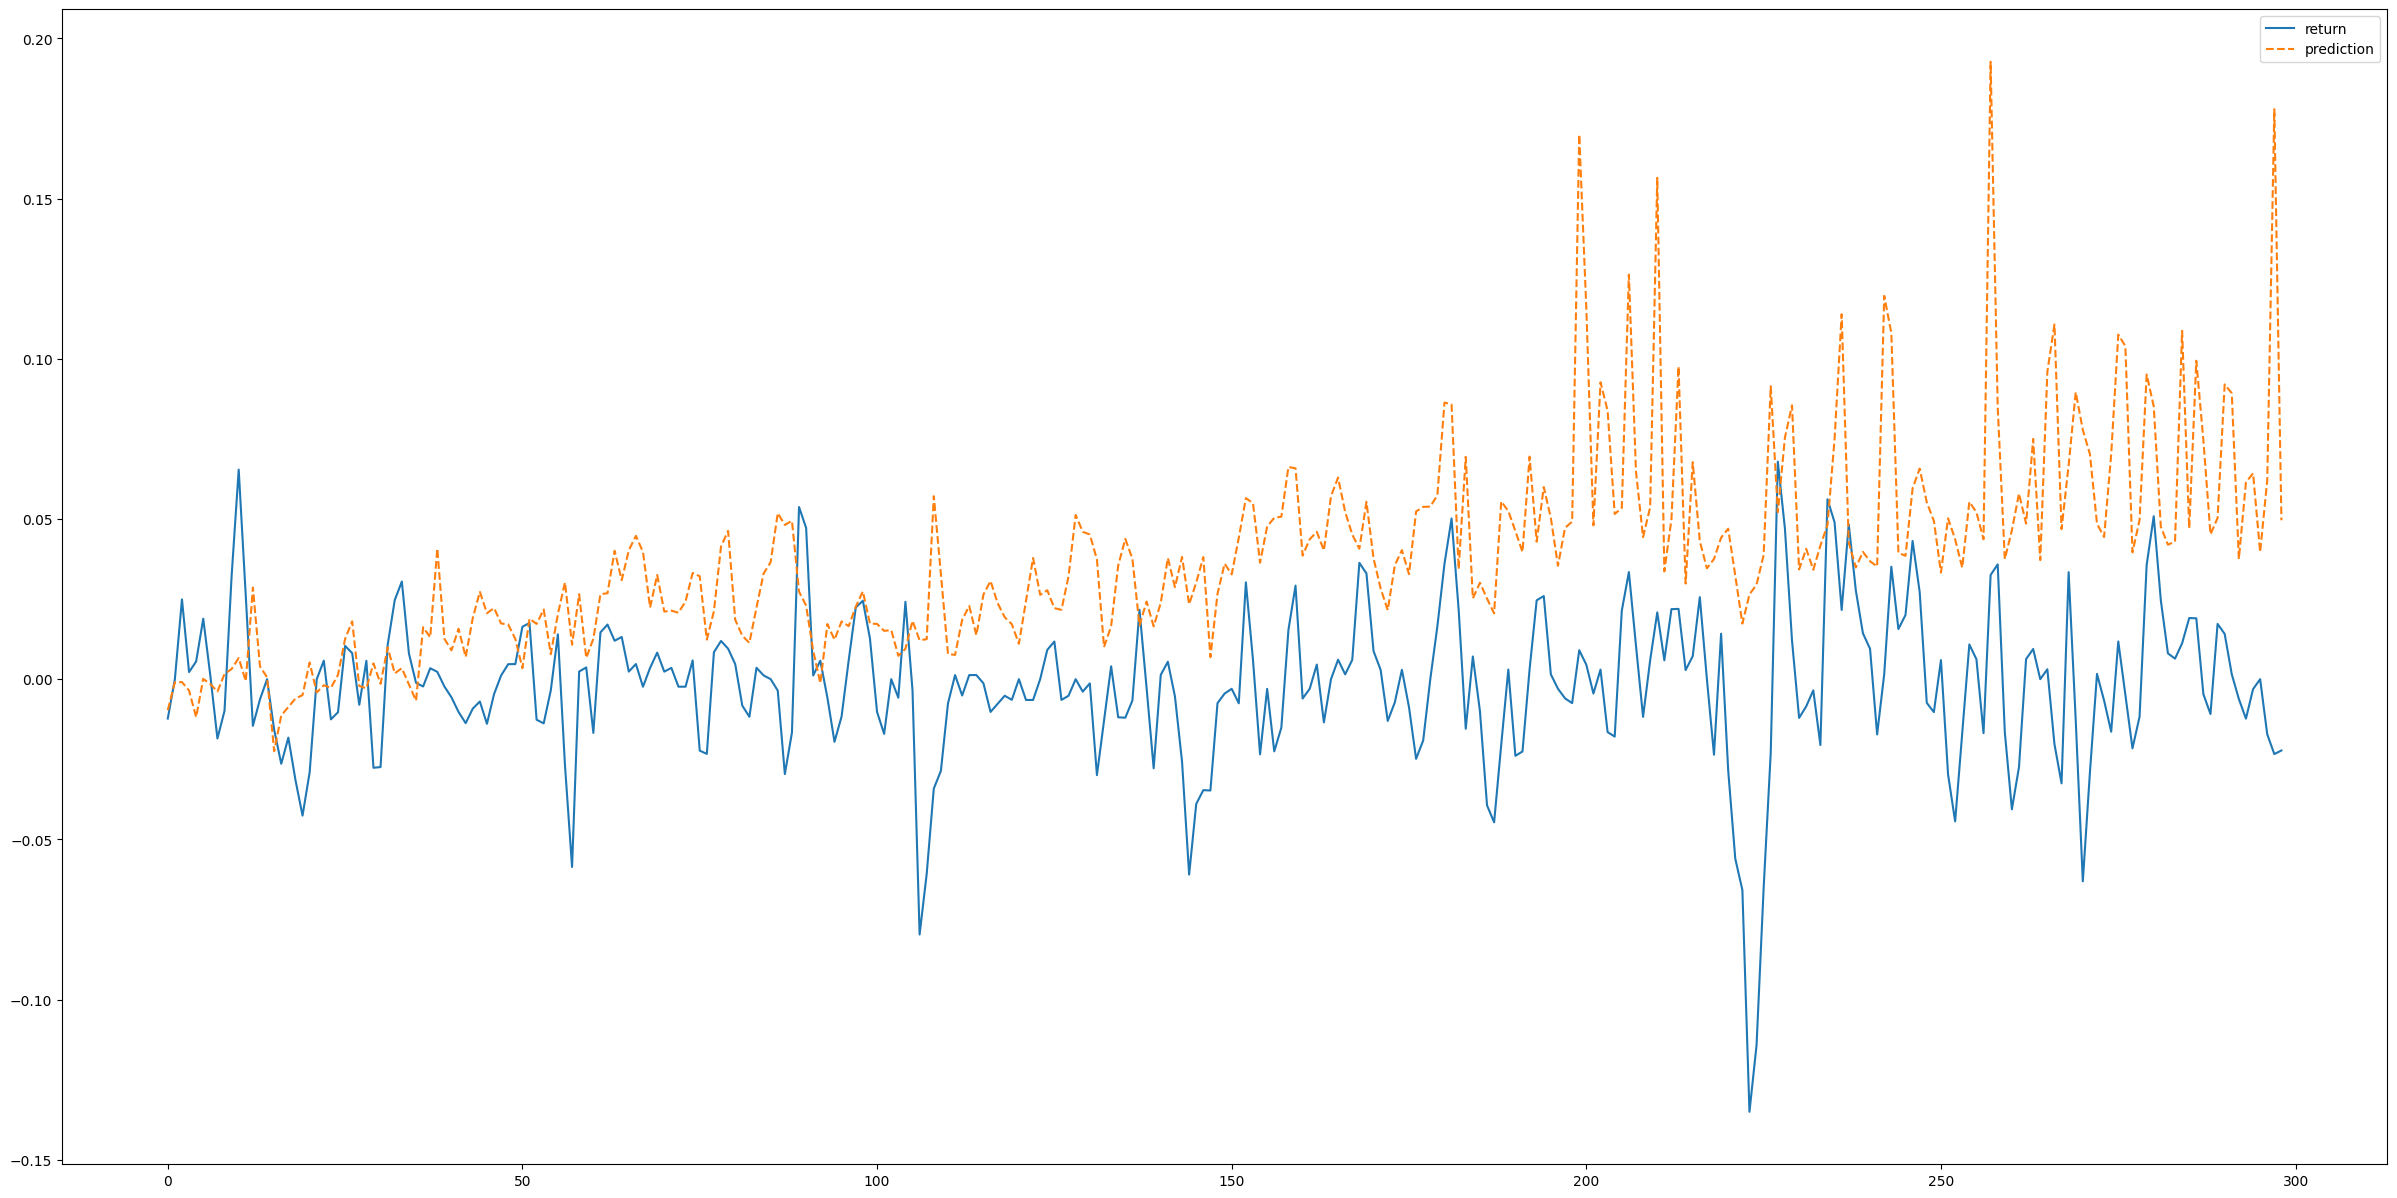

In [23]:
ax = df_progress[df_progress['asset'] == asset_type][['return']].plot(figsize=(30, 15))
df_progress[df_progress['asset'] == asset_type]['prediction'].plot(ax=ax, style="--", legend="prediction")

# Time Series Cross Validation (create splits for train sets)

In [24]:
tss = TimeSeriesSplit(n_splits=5,       #split 1000 days into 5 section (same as n_folds in lgbm ?)
                      test_size=60,      #each fold contains 60days
                      gap=2)            #gap of training set ends and test set begins ?

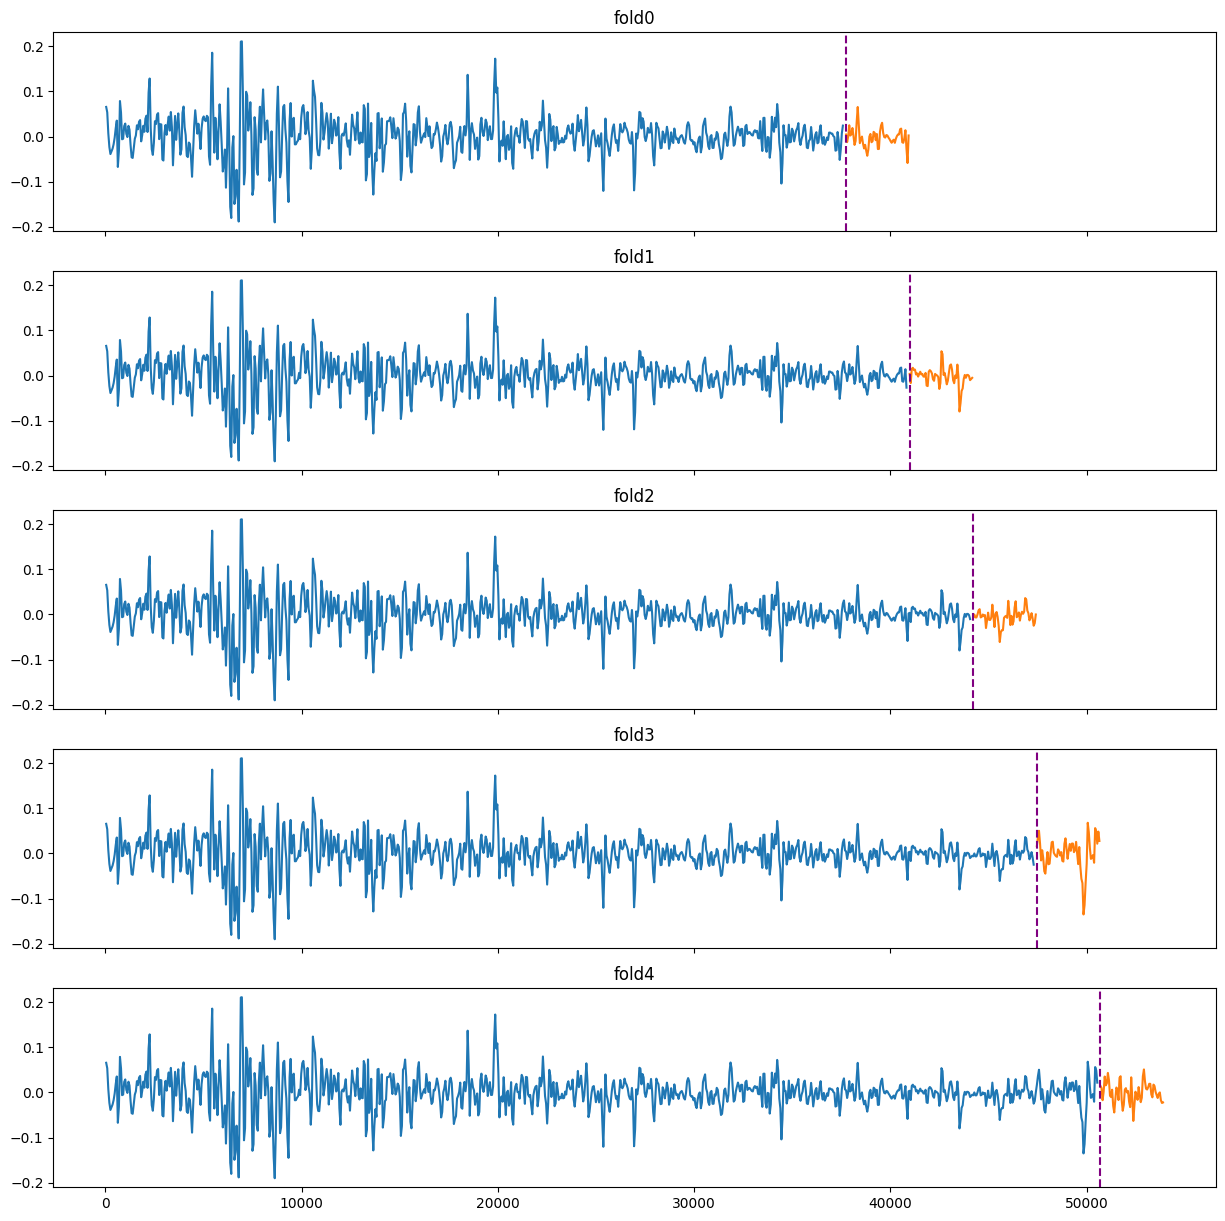

In [25]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)
fold = 0
df_asset = df[df['asset'] == asset_type].copy()
for train_idx, val_idx in tss.split(df_asset):
    train = df_asset.iloc[train_idx]
    test = df_asset.iloc[val_idx]
    train['return'].plot(ax=axs[fold],
                         title=f"fold{fold}")
    test['return'].plot(ax=axs[fold],
                        label="Test set")
    axs[fold].axvline(test.index.min(), color='purple', ls="--")        #create a vertical line seperating them
    fold += 1

# Forcasting Horizon

It is determined to be 700 days in the future by the competition.

# Lag Features

In [26]:
target_map = df_asset['return'].to_dict()

In [27]:
def add_lag(df, target_map):
    for i in [700, 750, 800, 850, 900, 950]:   #needs to be larger than the 700 days in the future.
        df[f'lag{i}'] = (df.index - i*54).map(target_map)       #since each asset row is distanted at 54 rows (by 53)
    return df

In [28]:
df_lag = add_lag(df_asset, target_map)
df_lag

date_time_x     open    close     high      low     volume  \
45       s45d1p50   9.6133   9.6254   9.6376   9.6012   152430.0   
99       s45d2p50   9.8196   9.9653  10.0017   9.8196  1113722.0   
153      s45d3p50  10.2323  10.2566  10.2566  10.2323   287418.0   
207      s45d4p50  10.4751  10.4994  10.4994  10.4751   394498.0   
261      s45d5p50  10.3173  10.3294  10.3294  10.3052   189437.0   
...           ...      ...      ...      ...      ...        ...   
53667  s45d994p50   7.8047   7.7926   7.8047   7.7926     3972.0   
53721  s45d995p50   7.7683   7.7926   7.7926   7.7683     7650.0   
53775  s45d996p50   7.7683   7.7683   7.7683   7.7683    10592.0   
53829  s45d997p50   7.7926   7.7926   7.7926   7.7926        0.0   
53883  s45d998p50   7.6348   7.6348   7.6348   7.6348     8974.0   

              money  asset  day  interval  ... remainder10  remainder11  \
45     1.467436e+06     45    1        50  ...           1            1   
99     1.107282e+07     45    2        50  ...           2            2   
153    2.944832e+06     45    3        50  ...           3            3   
207    4.135446e+06     45    4        50  ...           4            4   
261    1.954645e+06     45    5        50  ...           5            5   
...             ...    ...  ...       ...  ...         ...          ...   
53667  3.097132e+04     45  994        50  ...           4            4   
53721  5.957695e+04     45  995        50  ...           5            5   
53775  8.232356e+04     45  996        50  ...           6            6   
53829  0.000000e+00     45  997        50  ...           7            7   
53883  6.856271e+04     45  998        50  ...           8            8   

       remainder12  remainder13    lag700    lag750    lag800    lag850  \
45               1            1       NaN       NaN       NaN       NaN   
99               2            2       NaN       NaN       NaN       NaN   
153              3            3       NaN       NaN       NaN       NaN   
207              4            4       NaN       NaN       NaN       NaN   
261              5            5       NaN       NaN       NaN       NaN   
...            ...          ...       ...       ...       ...       ...   
53667           10            6  0.000000  0.069493 -0.071426 -0.084689   
53721           11            7  0.053357  0.060946 -0.028934  0.022762   
53775            0            8  0.066992 -0.096993  0.123624  0.065909   
53829            1            9  0.010597 -0.082867  0.102332 -0.012888   
53883            2           10 -0.013703  0.072996  0.088016  0.054692   

         lag900    lag950  
45          NaN       NaN  
99          NaN       NaN  
153         NaN       NaN  
207         NaN       NaN  
261         NaN       NaN  
...         ...       ...  
53667  0.036126 -0.028459  
53721  0.034099 -0.040549  
53775  0.045915 -0.014139  
53829  0.042871  0.034016  
53883 -0.043899  0.027662  

[998 rows x 50 columns]

In [29]:
df[df['asset'] == 0]

date_time_x     open    close     high      low    volume         money  \
0         s0d1p50  24.3731  24.3852  24.3852  24.3731  170476.0  4.157520e+06   
54        s0d2p50  23.5963  23.5963  23.5963  23.5963  221244.0  5.219770e+06   
108       s0d3p50  23.7298  23.7298  23.7298  23.7298  121576.0  2.885506e+06   
162       s0d4p50  24.2760  24.2760  24.2760  24.2760  210551.0  5.110239e+06   
216       s0d5p50  26.2909  26.2909  26.2909  26.2909  641620.0  1.687213e+07   
...           ...      ...      ...      ...      ...       ...           ...   
53622   s0d994p50  12.4900  12.5021  12.5021  12.4900  159332.0  1.992671e+06   
53676   s0d995p50  12.3808  12.3808  12.3808  12.3808  135814.0  1.680749e+06   
53730   s0d996p50  12.1623  12.1744  12.1744  12.1623  166255.0  2.023744e+06   
53784   s0d997p50  12.3565  12.3686  12.3686  12.3565   97940.0  1.210867e+06   
53838   s0d998p50  12.2230  12.2230  12.2230  12.2230   35328.0  4.317244e+05   

       asset  day  interval  ... remainder4  remainder5  remainder6  \
0          0    1        50  ...          1           1           1   
54         0    2        50  ...          2           2           2   
108        0    3        50  ...          3           3           3   
162        0    4        50  ...          0           4           4   
216        0    5        50  ...          1           0           5   
...      ...  ...       ...  ...        ...         ...         ...   
53622      0  994        50  ...          2           4           4   
53676      0  995        50  ...          3           0           5   
53730      0  996        50  ...          0           1           0   
53784      0  997        50  ...          1           2           1   
53838      0  998        50  ...          2           3           2   

       remainder7  remainder8  remainder9  remainder10  remainder11  \
0               1           1           1            1            1   
54              2           2           2            2            2   
108             3           3           3            3            3   
162             4           4           4            4            4   
216             5           5           5            5            5   
...           ...         ...         ...          ...          ...   
53622           0           2           4            4            4   
53676           1           3           5            5            5   
53730           2           4           6            6            6   
53784           3           5           7            7            7   
53838           4           6           8            8            8   

      remainder12  remainder13  
0               1            1  
54              2            2  
108             3            3  
162             4            4  
216             5            5  
...           ...          ...  
53622          10            6  
53676          11            7  
53730           0            8  
53784           1            9  
53838           2           10  

[998 rows x 44 columns]

# Testing implementing Time-Series Cross Validation onto the Prediction Function

In [30]:
df = create_features(df_train_market, df_train_fund, df_train_returns)

In [31]:
FEATURES0 = ['asset', 'transactionAmount', 'pe_ttm', 'pe']
FEATURES1 = ['open', 'close', 'high', 'low', 'volume', 'money','turnoverRatio','transactionAmount', 'pe_ttm', 'pe', 'pb', 'ps', 'pcf']
FEATURES2 = ['pcf', 'pe', 'pb', 'pe_ttm', 'ps', 'transactionAmount', 'turnoverRatio', 'money']
FEATURES3 = ['pcf', 'pe', 'pb', 'pe_ttm', 'ps', 'transactionAmount', 'turnoverRatio', 'money', 'open', 'close', 'high', 'low']
FEATURES4 = ['pcf', 'pe', 'pb', 'pe_ttm', 'ps', 'transactionAmount', 'turnoverRatio', 'money', 'open', 'close', 'high', 'low'] + [f"period{i}" for i in range(2, 14)] + [f"remainder{i}" for i in range(2, 14)]
FEATURES5 = FEATURES4 + [f"lag{i}" for i in [700, 750, 800, 850, 900, 950]]
feature_list = [FEATURES0, FEATURES1, FEATURES2, FEATURES3, FEATURES4, FEATURES5]
TARGET = 'return'    #always

def add_lag(df, target_map):
    for i in [700, 750, 800, 850, 900, 950]:   #needs to be larger than the 700 days in the future.
        df[f'lag{i}'] = (df.index - i*54).map(target_map)       #since each asset row is distanted at 54 rows (by 53)
    return df

def train_predict_compare_tss(df, asset_type, features, RETURN_FI=False, RETURN_RESULTS=False):
    # major changes to previous one: previous we have set arbitary where to split train and test set (e.g. 7:3)
    # this version make uses tss to have multiple folds of train and test sets (*without information leakage)
    
    tss = TimeSeriesSplit(n_splits=5,       #split 1000 days into 5 section (same as n_folds in lgbm ?)
                      test_size=60,      #each fold contains 60days
                      gap=2)            #gap of training set ends and test set begins ?
    
    #lag features
    df = df[df['asset'] == asset_type]
    target_map = df['return'].to_dict()
    df = add_lag(df, target_map)

    fold = 0
    predictions = []
    scores = []
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]

        x_train = train[features]
        y_train = train[TARGET]
        x_test = test[features]
        y_test = test[TARGET]   #only exists for training set

        reg = xgb.XGBRegressor(booster="gbtree", n_estimators=2000, learning_rate=0.1, max_depth=5)
        reg.fit(x_train, y_train, 
            eval_set=[(x_train, y_train), (x_test, y_test)],
            verbose=20)

        fi = pd.DataFrame(data=reg.feature_importances_,
                index=reg.feature_names_in_,
                columns=['importance'])
        
        if RETURN_FI:   #used for debugging which feature is more significant 
            return fi

        test['prediction'] = reg.predict(x_test)
        df_progress = pd.merge(df, test[['asset', 'day', 'prediction']],
                            left_on=["asset", "day"], 
                            right_on=["asset", "day"])
        df_progress = df_progress[['date_time_x', 'return', 'prediction']]

        y_prediction = test['prediction']
        
        ax = df_progress[['return']].plot(figsize=(30, 15))
        df_progress[['prediction']].plot(ax=ax, style="--")

        predictions.append(y_prediction)
        score = np.sqrt(mean_squared_error(y_test, y_prediction))
        scores.append(score)
        fold += 1
    
    return scores
    

[0]	validation_0-rmse:0.44930	validation_1-rmse:0.45408
[20]	validation_0-rmse:0.06657	validation_1-rmse:0.08005
[40]	validation_0-rmse:0.02774	validation_1-rmse:0.05027
[60]	validation_0-rmse:0.02198	validation_1-rmse:0.04882
[80]	validation_0-rmse:0.01776	validation_1-rmse:0.04857
[100]	validation_0-rmse:0.01462	validation_1-rmse:0.04948
[120]	validation_0-rmse:0.01203	validation_1-rmse:0.04978
[140]	validation_0-rmse:0.01019	validation_1-rmse:0.05067
[160]	validation_0-rmse:0.00871	validation_1-rmse:0.05103
[180]	validation_0-rmse:0.00726	validation_1-rmse:0.05179
[200]	validation_0-rmse:0.00626	validation_1-rmse:0.05190
[220]	validation_0-rmse:0.00536	validation_1-rmse:0.05200
[240]	validation_0-rmse:0.00446	validation_1-rmse:0.05204
[260]	validation_0-rmse:0.00378	validation_1-rmse:0.05209
[280]	validation_0-rmse:0.00320	validation_1-rmse:0.05222
[300]	validation_0-rmse:0.00274	validation_1-rmse:0.05234
[320]	validation_0-rmse:0.00232	validation_1-rmse:0.05233
[340]	validation_0-r

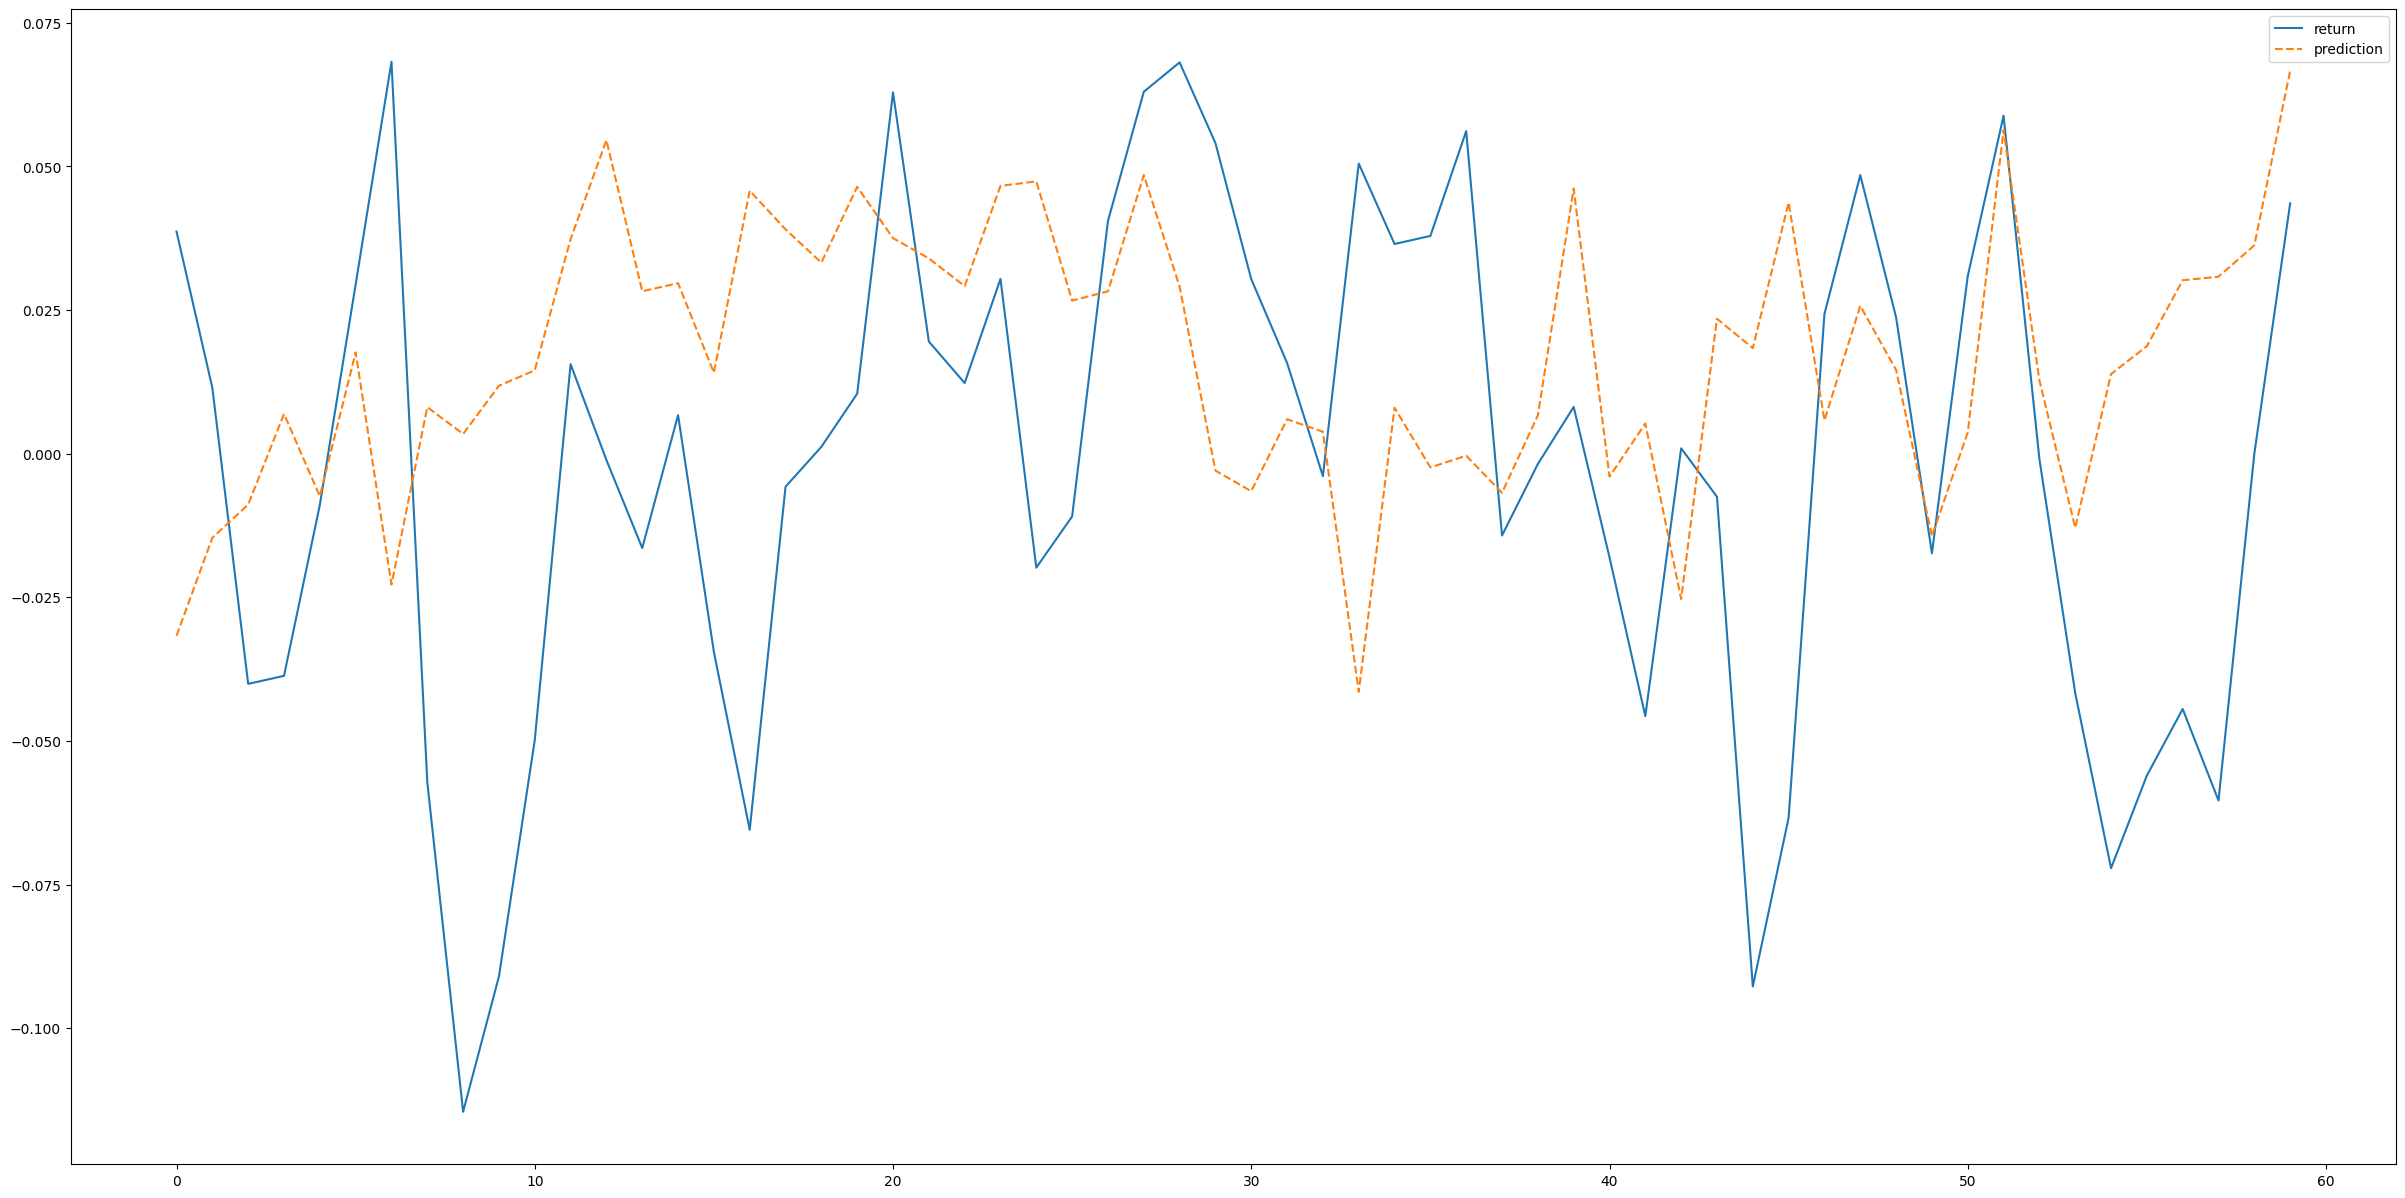

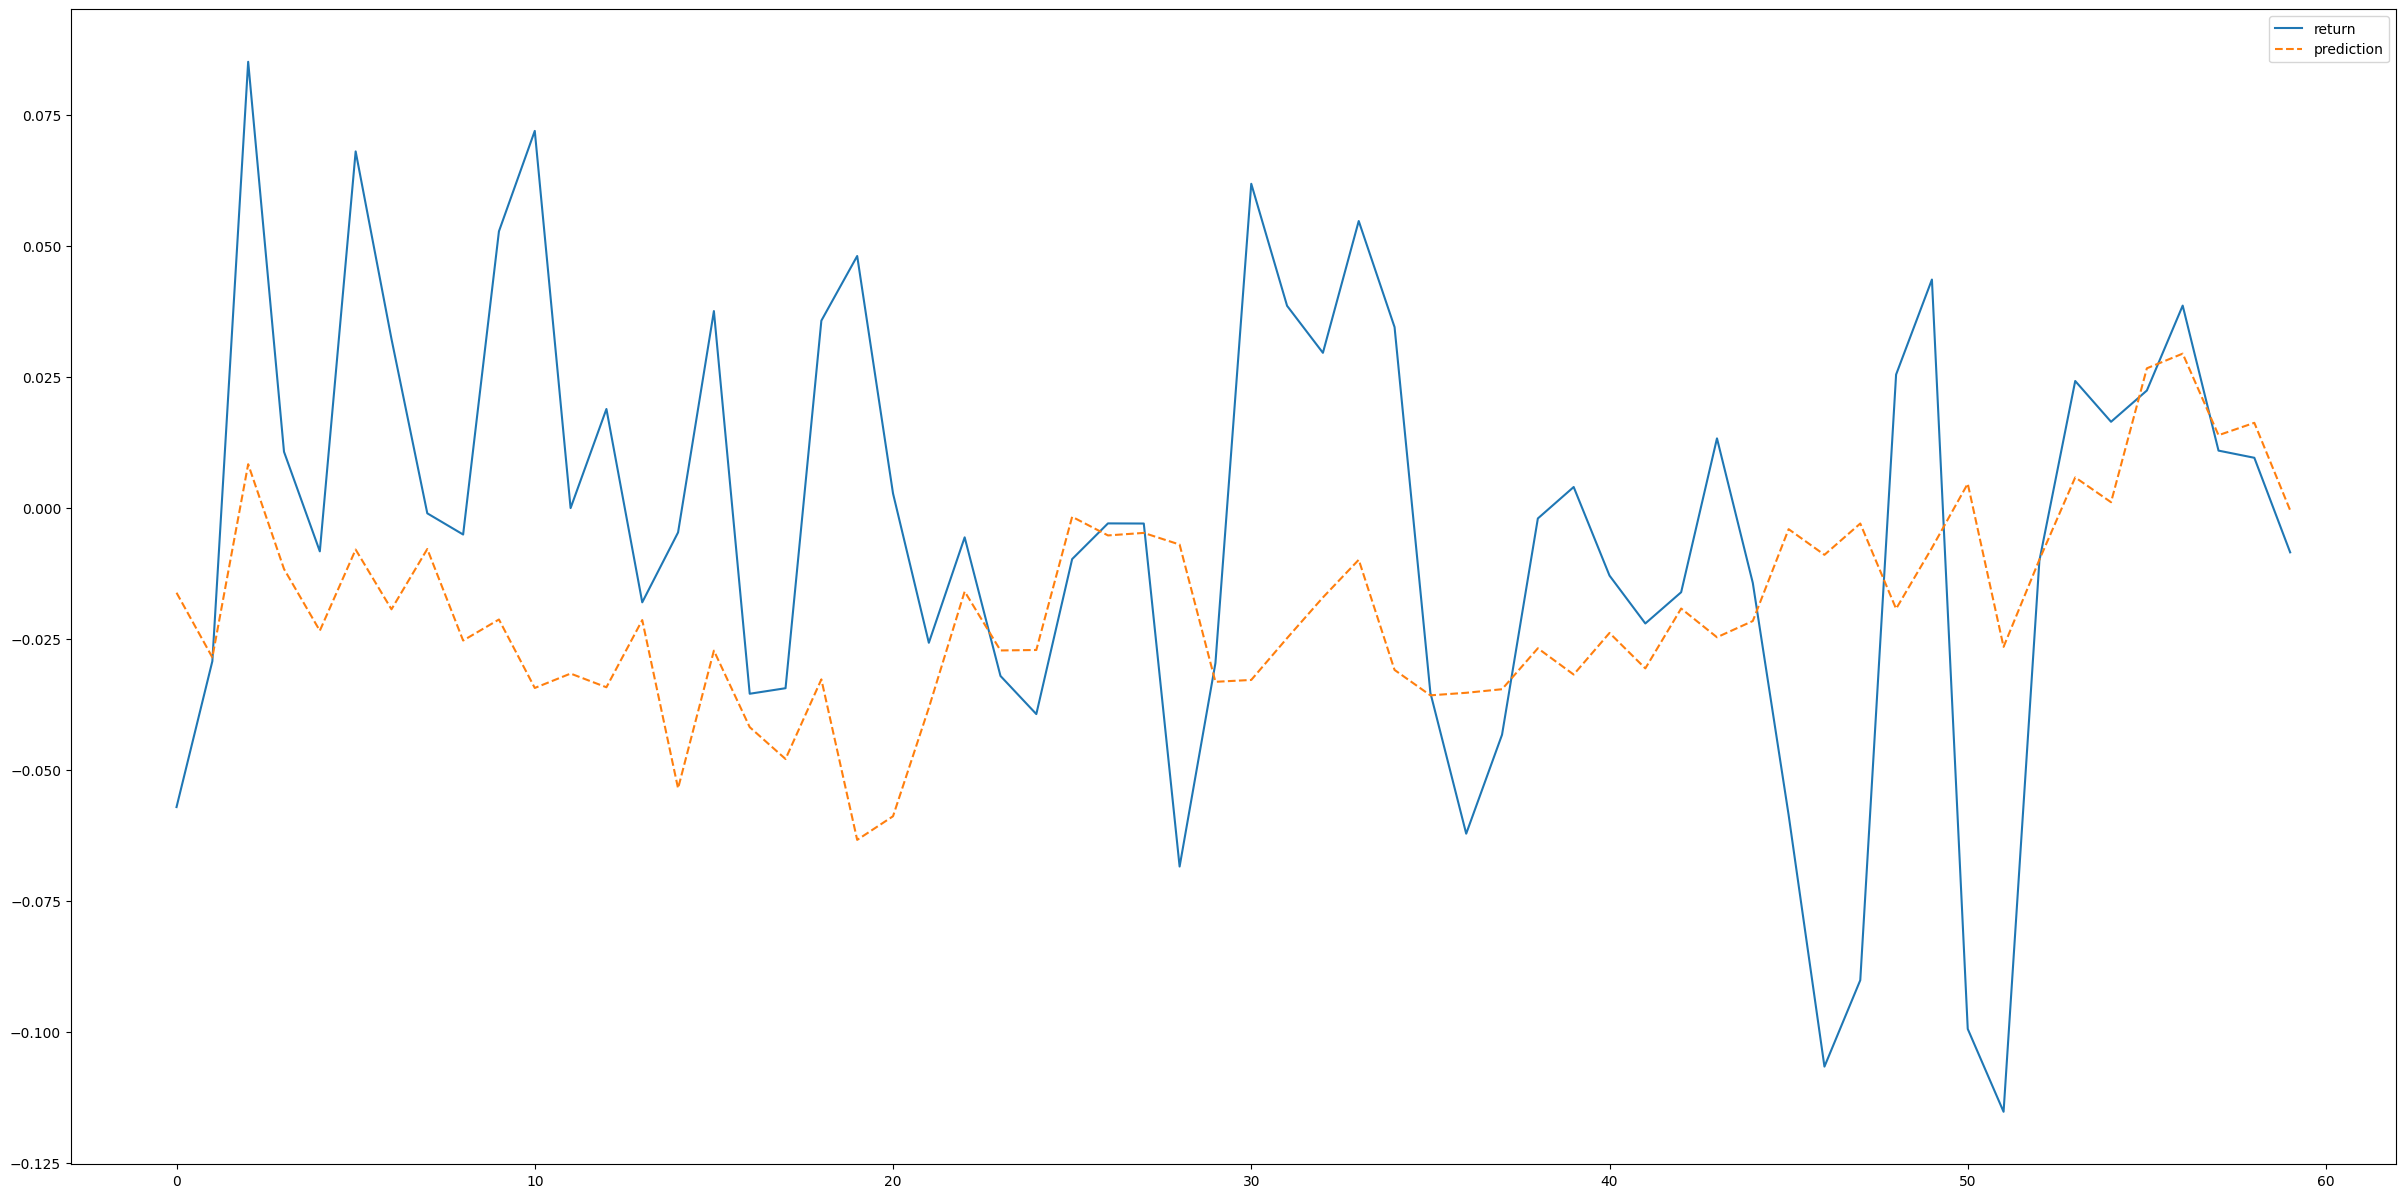

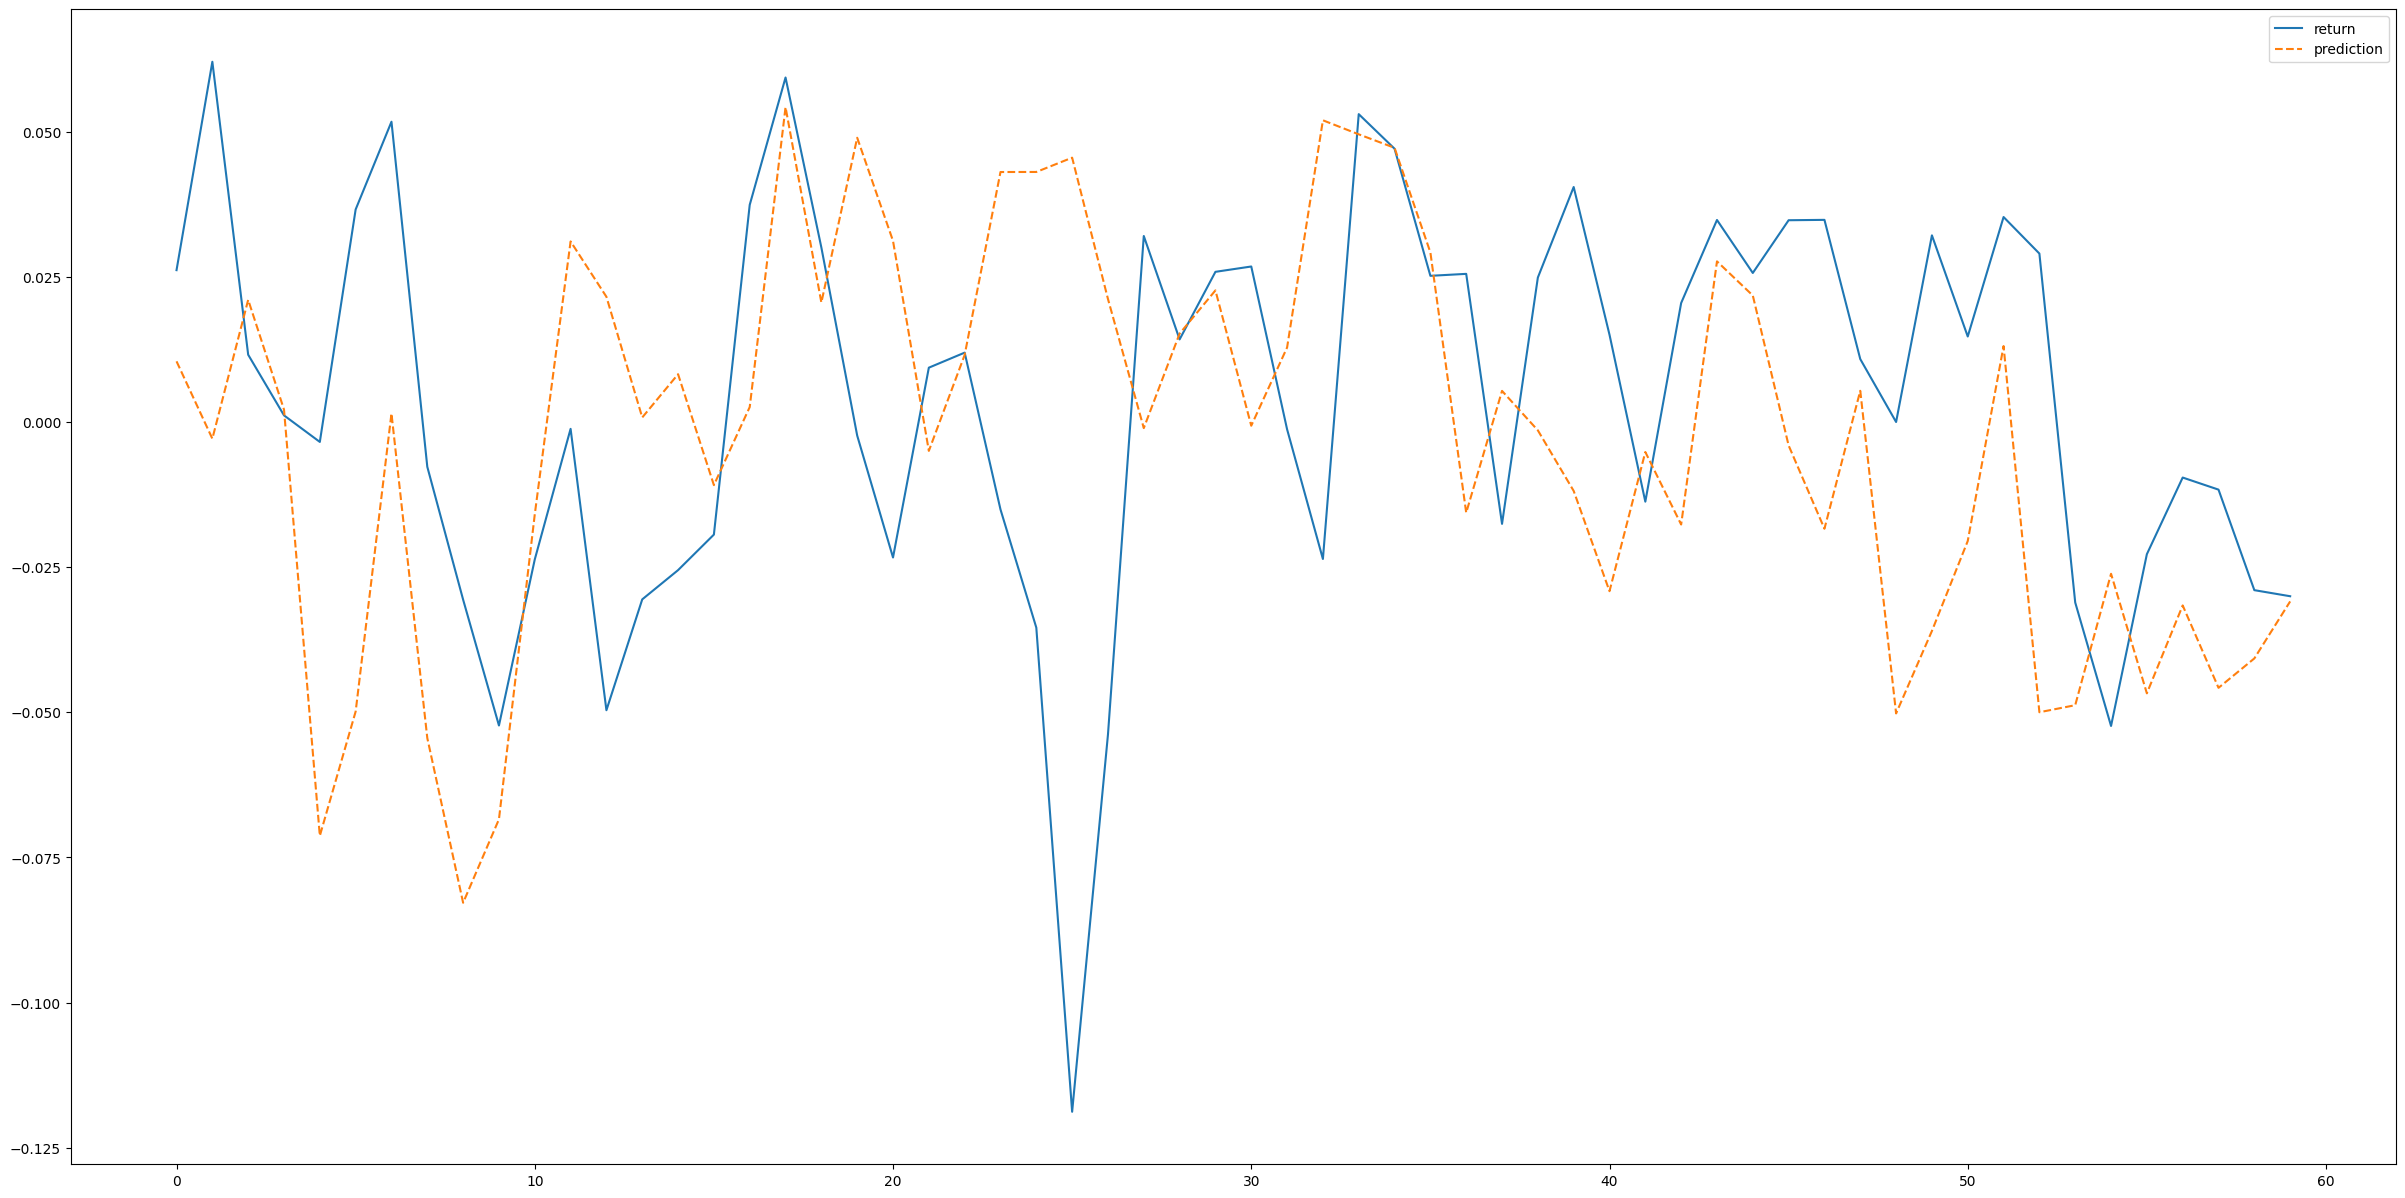

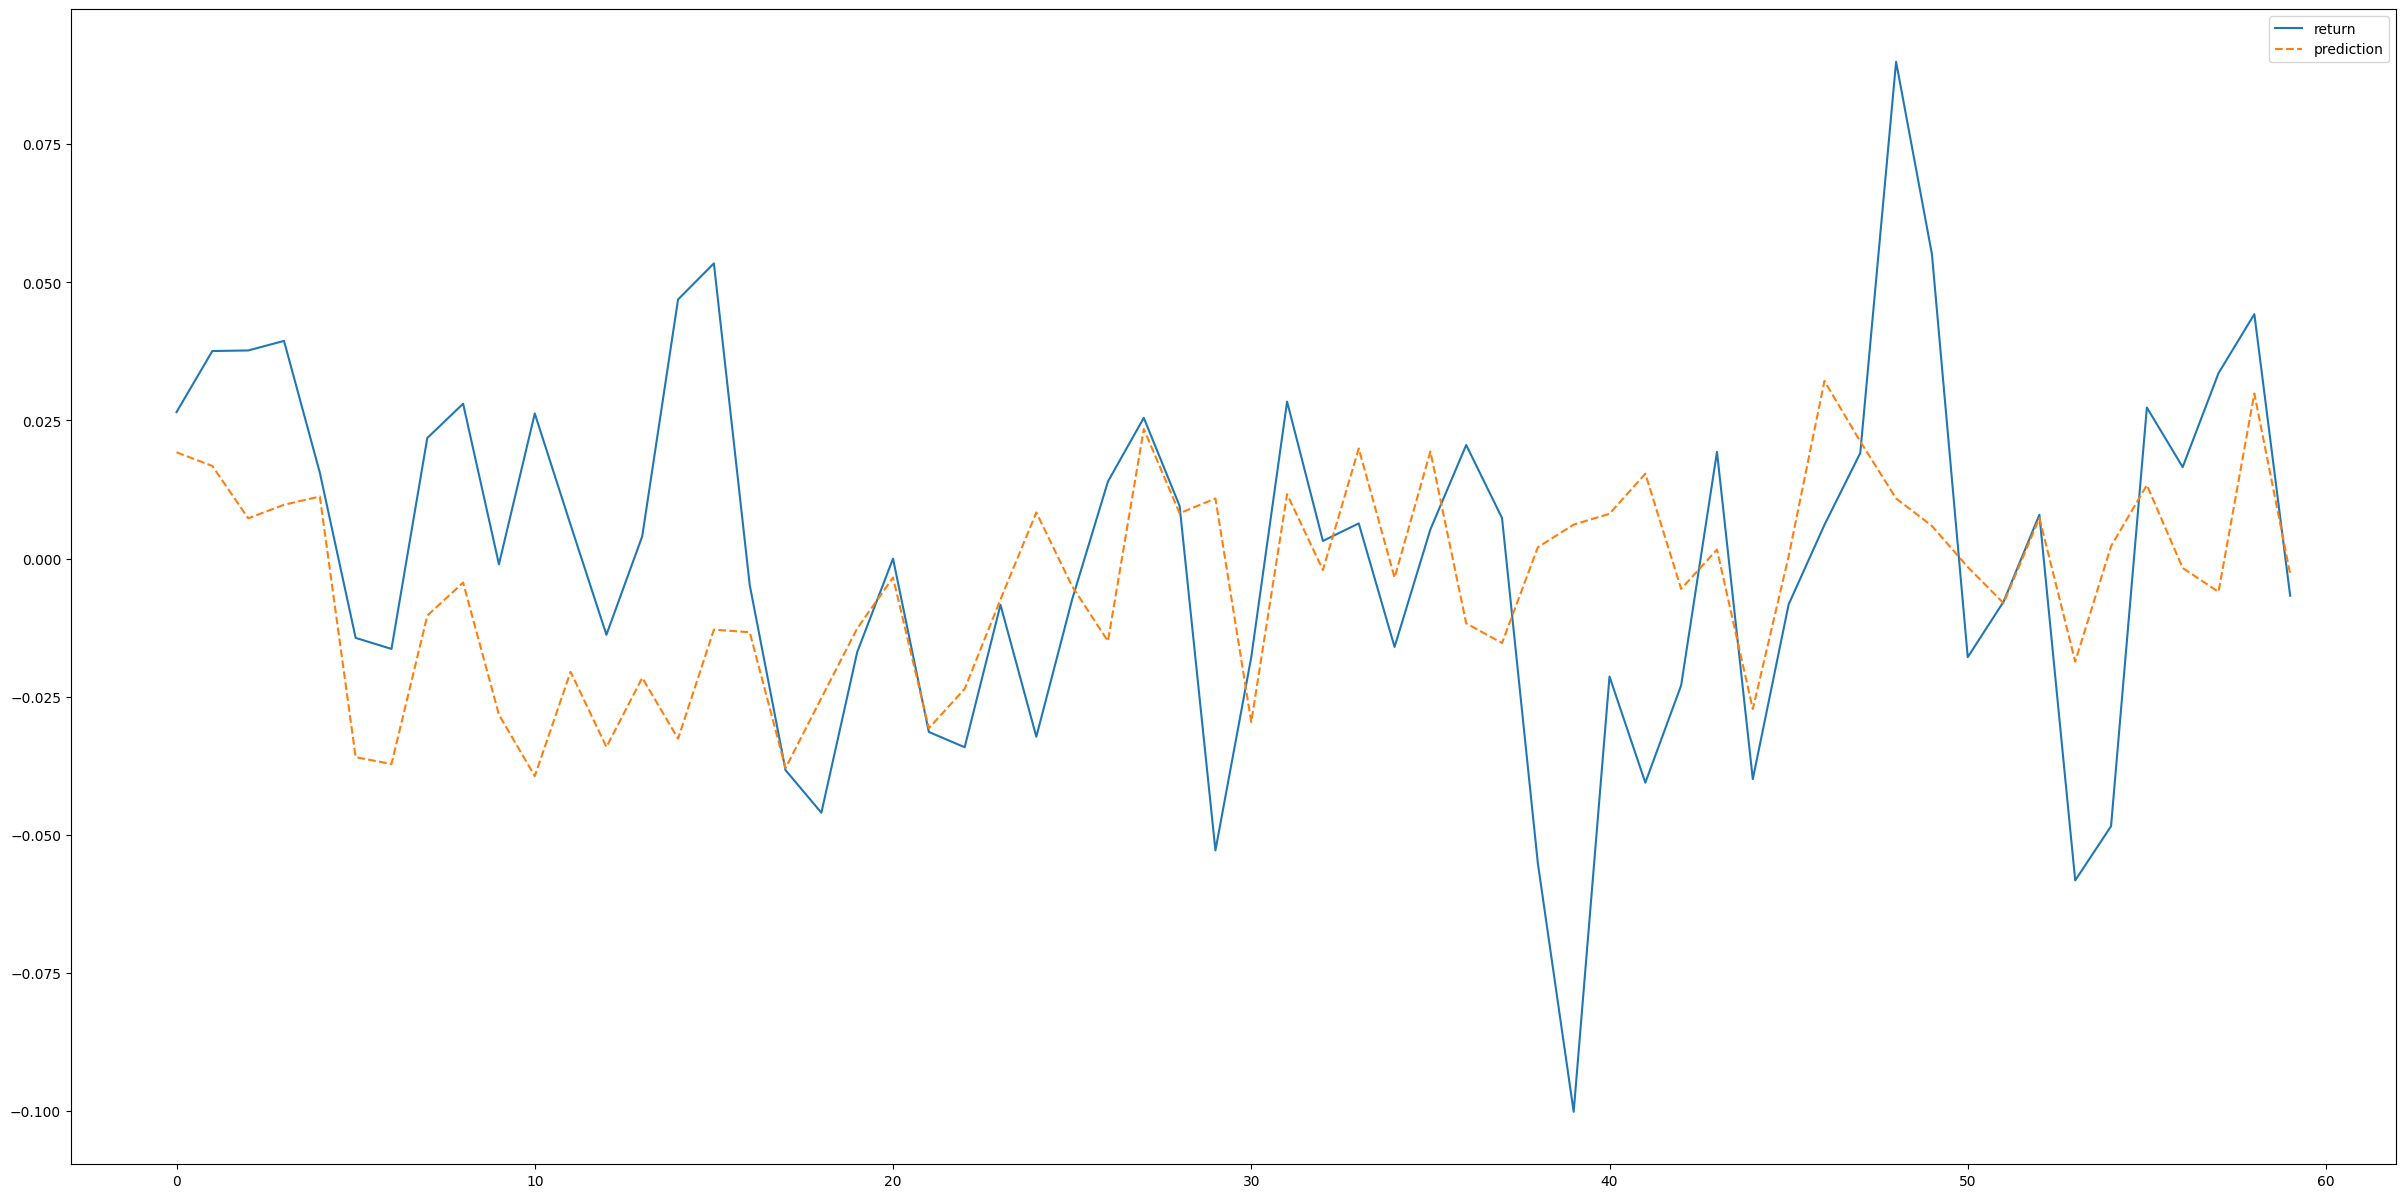

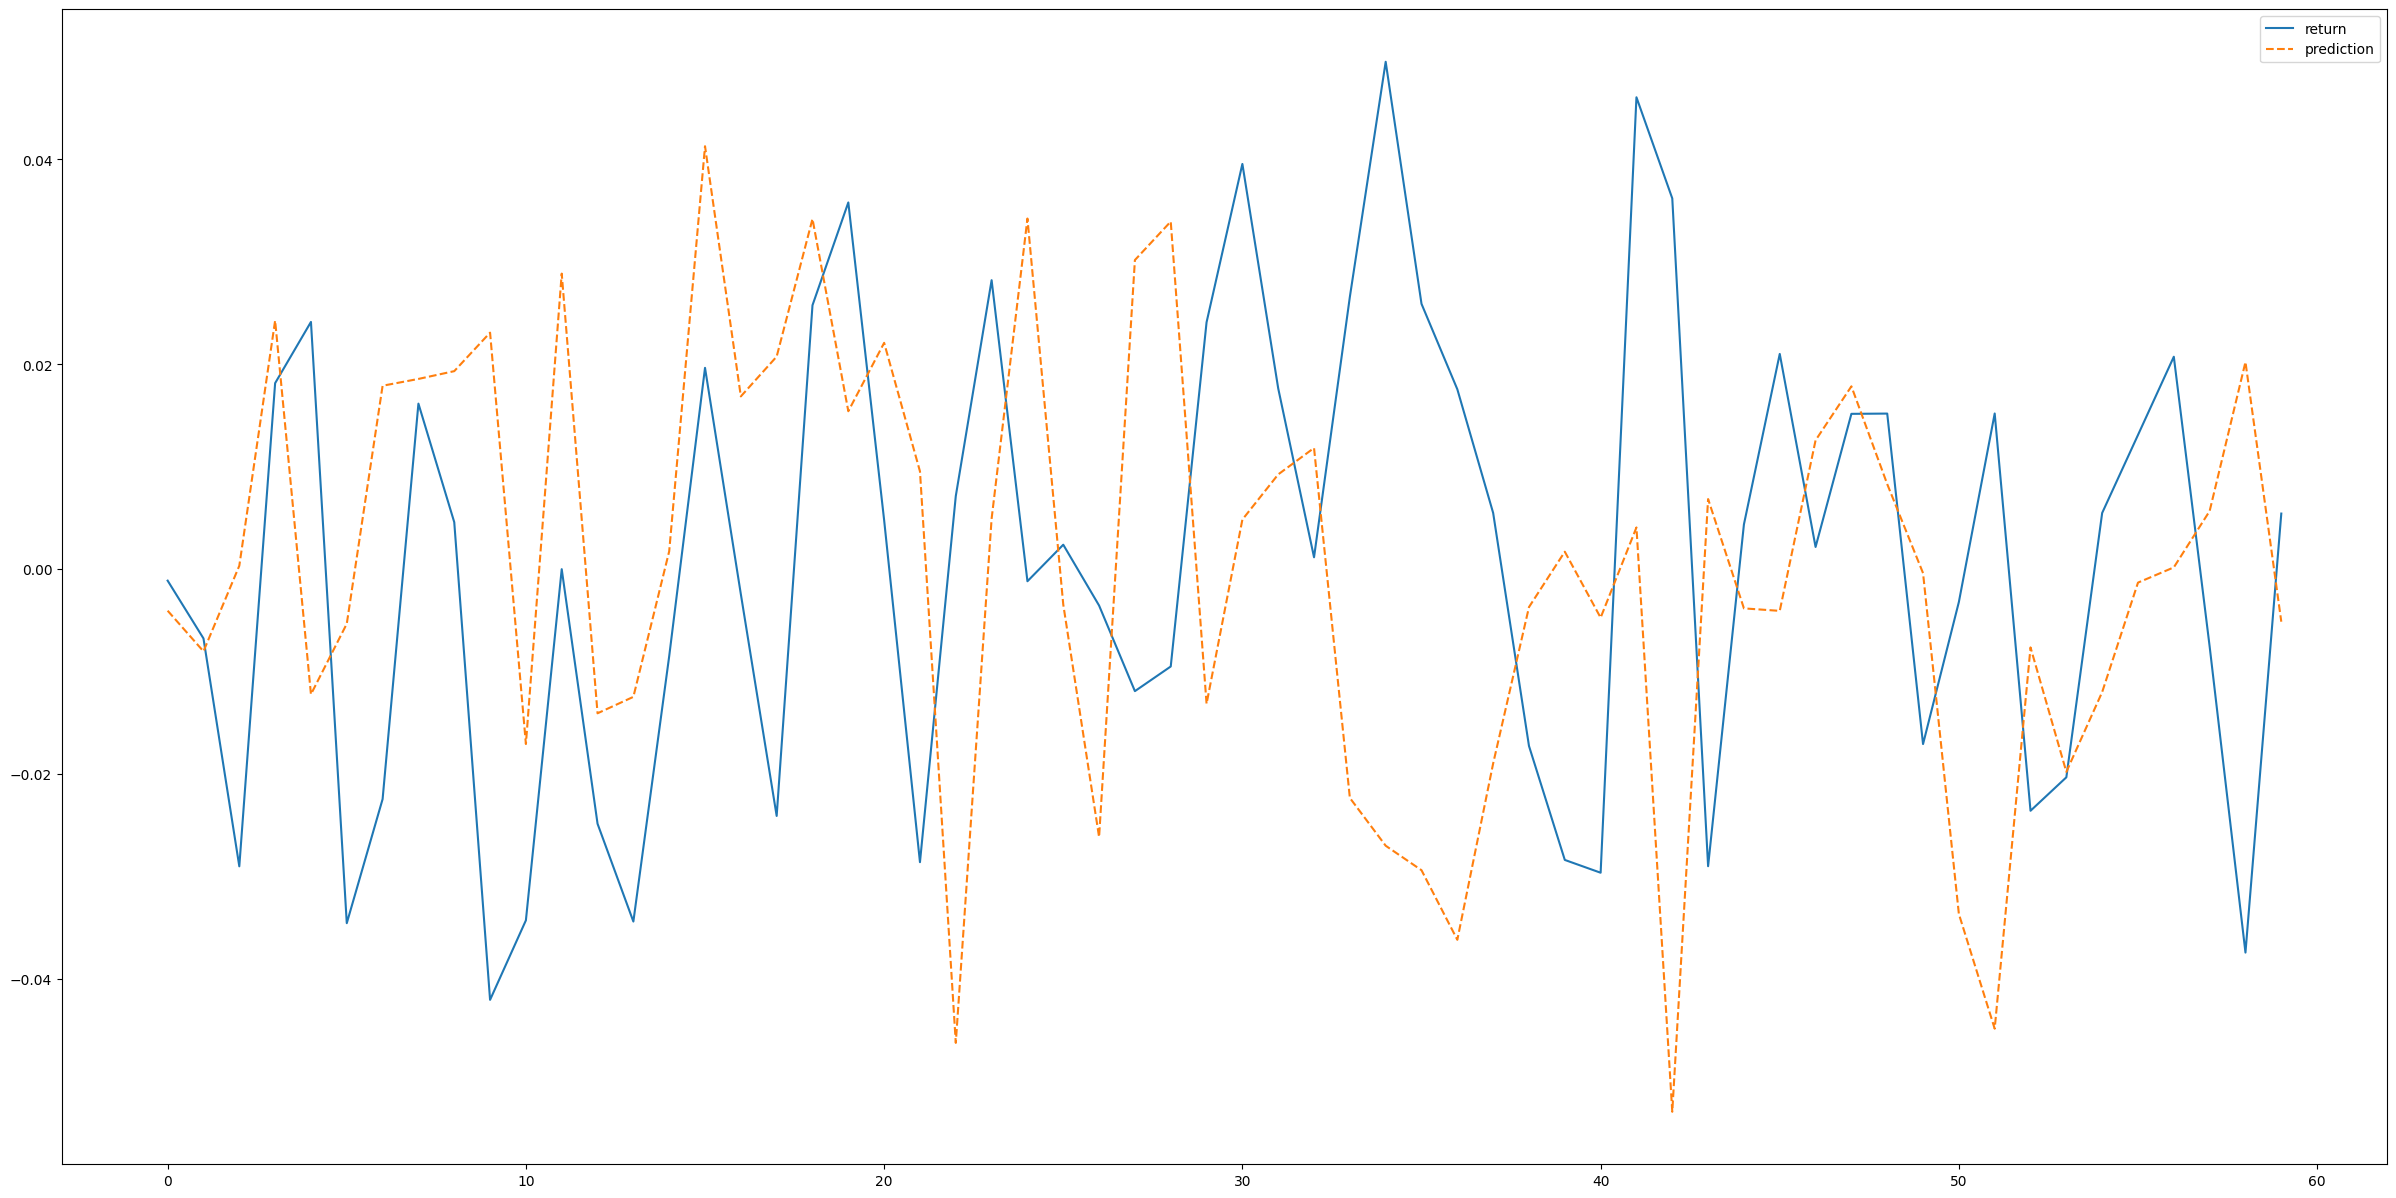

In [32]:
score_res = train_predict_compare_tss(df, 41, feature_list[5], False, False)
print(sum(score_res) / len(score_res))

In [33]:
def accumulate_feature_importance2():
    #this function accumlate the FI dataframe of all features used
    df_temp = train_predict_compare_tss(df, 0, feature_list[5], True)
    for i in range(1, 54):
        df_temp += train_predict_compare_tss(df, i, feature_list[5], True)
    df_temp = df_temp.sort_values("importance", ascending=False)
    return df_temp

accumulate_feature_importance2()

[0]	validation_0-rmse:0.45220	validation_1-rmse:0.46027
[20]	validation_0-rmse:0.06626	validation_1-rmse:0.07158
[40]	validation_0-rmse:0.02408	validation_1-rmse:0.03517
[60]	validation_0-rmse:0.01695	validation_1-rmse:0.03312
[80]	validation_0-rmse:0.01379	validation_1-rmse:0.03339
[100]	validation_0-rmse:0.01147	validation_1-rmse:0.03370
[120]	validation_0-rmse:0.00957	validation_1-rmse:0.03333
[140]	validation_0-rmse:0.00791	validation_1-rmse:0.03312
[160]	validation_0-rmse:0.00677	validation_1-rmse:0.03318
[180]	validation_0-rmse:0.00565	validation_1-rmse:0.03347
[200]	validation_0-rmse:0.00489	validation_1-rmse:0.03358
[220]	validation_0-rmse:0.00419	validation_1-rmse:0.03343
[240]	validation_0-rmse:0.00358	validation_1-rmse:0.03340
[260]	validation_0-rmse:0.00304	validation_1-rmse:0.03343
[280]	validation_0-rmse:0.00264	validation_1-rmse:0.03338
[300]	validation_0-rmse:0.00223	validation_1-rmse:0.03335
[320]	validation_0-rmse:0.00192	validation_1-rmse:0.03330
[340]	validation_0-r

# FINAL BOSS: Predicting the future

In [ ]:
df_train = create_features(df_train_market, df_train_fund, df_train_returns)
df_test = create_features(df_market, df_fund)

returns_copy = df_train.copy()
returns_avg = [ returns_copy[returns_copy['asset'] == i]['return'].mean() for i in range(54)]

In [ ]:
def add_lag(df, target_map):
    for i in [700, 750, 800, 850, 900, 950]:   #needs to be larger than the 700 days in the future.
        df[f'lag{i}'] = (df.index - i*54).map(target_map)       #since each asset row is distanted at 54 rows (by 53)
    return df

In [ ]:
FEATURES0 = ['asset', 'transactionAmount', 'pe_ttm', 'pe']
FEATURES1 = ['open', 'close', 'high', 'low', 'volume', 'money','turnoverRatio','transactionAmount', 'pe_ttm', 'pe', 'pb', 'ps', 'pcf']
FEATURES2 = ['pcf', 'pe', 'pb', 'pe_ttm', 'ps', 'transactionAmount', 'turnoverRatio', 'money']
FEATURES3 = ['pcf', 'pe', 'pb', 'pe_ttm', 'ps', 'transactionAmount', 'turnoverRatio', 'money', 'open', 'close', 'high', 'low']
FEATURES4 = ['pcf', 'pe', 'pb', 'pe_ttm', 'ps', 'transactionAmount', 'turnoverRatio', 'money', 'open', 'close', 'high', 'low'] + [f"period{i}" for i in range(2, 14)] + [f"remainder{i}" for i in range(2, 14)]
FEATURES5 = FEATURES4 + [f"lag{i}" for i in [700, 750, 800, 850, 900, 950]]
feature_list = [FEATURES0, FEATURES1, FEATURES2, FEATURES3, FEATURES4, FEATURES5]
TARGET = 'return'    #always

def train_predict(df_train, df_test, asset_type, features):
    # major changes to previous one: previous we have set arbitary where to split train and test set (e.g. 7:3)
    # this version make uses tss to have multiple folds of train and test sets (*without information leakage)
        
    df_train = df_train[df_train['asset'] == asset_type]
    df_test = df_test[df_test['asset'] == asset_type]

    train_map = df_train['return'].to_dict()
    df_train = add_lag(df_train, train_map)
    df_train['isFuture'] = False
    df_test['isFuture'] = True
    df_test.index += 53892
    train_and_test = pd.concat([df_train, df_test])
    tat_map = train_and_test['return'].to_dict()
    train_and_test = add_lag(train_and_test, tat_map)
    test_features = train_and_test[train_and_test['isFuture'] == True].copy()
    
    x_all = df_train[features]
    y_all = df_train[TARGET]

    reg = xgb.XGBRegressor(n_estimators=2500,
                        booster="gbtree",
                        objective="reg:squaredlogerror",
                        max_depth=2,            #high value leads to overfitting
                        learning_rate=0.4,      #higher value leads to overfitting
                        min_child_weight=3,             #higher value prevent overfitting (1000:700 ratio makes it easy to overfit)
                        subsample=1,
                        )
    
    reg.fit(x_all, y_all,
            eval_set=[(x_all, y_all)],
            verbose=20)
    
    test_features['prediction'] = reg.predict(test_features[features])
    df_progress = test_features[['prediction']]
    avg_adjusted_prediction = df_progress['prediction'] - (df_progress['prediction'].mean() - returns_avg[asset_type])
    return avg_adjusted_prediction  

In [ ]:
def train_predict_all():
    df_train = create_features(df_train_market, df_train_fund, df_train_returns)
    df_test = create_features(df_market, df_fund)
    df_res = train_predict(df_train, df_test, 0, feature_list[5])
    for i in range(1, 54):
        df_res = pd.concat((df_res, train_predict(df_train, df_test, i, feature_list[5])))
    df_copy = df_res.sort_index()
    df_copy = df_copy.reset_index()
    dt_col = df_fund['date_time']
    df_copy['date_time'] = dt_col
    df_copy = df_copy[['date_time', 'prediction']]
    df_copy.columns = ['date_time', 'return']
    return df_copy

df_res = train_predict_all()
df_res
        

NameError: name 'create_features' is not defined

# Following is basically cheating (future hacking and hyper-parameter tuning)

In [ ]:
df_2day_return = df_market[df_market['interval'] == 50]
df_2day_return = df_2day_return.reset_index()
df_2day_return = df_2day_return[['date_time', 'close']]
close_map = df_2day_return['close'].to_dict()

df_2day_return['close_2day_later'] = (df_2day_return.index + 2*54).map(close_map)
df_2day_return['2day_return'] = (df_2day_return['close_2day_later'] - df_2day_return['close']) / df_2day_return['close']
df_2day_return = df_2day_return.fillna(0)
real_2day_returns = df_2day_return['2day_return']

df_2day_return2 = df_2day_return.copy()
df_2day_return2['close_2day_later'] = (df_2day_return2.index - 2*54).map(close_map)
df_2day_return2['2day_return'] = (df_2day_return2['close_2day_later'] - df_2day_return2['close']) / df_2day_return2['close']
df_2day_return2 = df_2day_return2.fillna(0)
real_2day_returns2 = df_2day_return2['2day_return']

real_2day_returns2

In [ ]:
print(df_res['return'].corr(real_2day_returns))
print(df_res['return'].corr(real_2day_returns2))


0.04444018247635979
0.048755552777924746

on

reg = xgb.XGBRegressor(n_estimators=2000,
                    booster="gbtree",
                    objective="reg:linear",
                    max_depth=2,            #high value leads to overfitting
                    learning_rate=0.4,
                    min_child_weight=3,             #higher value prevent overfitting (1000:700 ratio makes it easy to overfit)
                    subsample=1,
                    )

0.046394130695381716
0.044112731505098625

on

reg = xgb.XGBRegressor(n_estimators=2000,
                    booster="gbtree",
                    objective="reg:linear",
                    max_depth=2,            #high value leads to overfitting
                    learning_rate=0.5,
                    min_child_weight=3,             #higher value prevent overfitting (1000:700 ratio makes it easy to overfit)
                    subsample=1,
                    )

learning rate at between 0.4 and 0.5 is best.
n_estimators at 2500 is good enough.